## Description: a consumer finance company needs to make a decision for loan approval based on the applicant’s profile.
Two types of risks are associated with the bank’s decision:

- If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company
- If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company

The company wants to understand the driving factors (or driver variables) behind loan default. We need to use EDA to understand how consumer attributes and loan attributes influence the tendency of default

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from datetime import datetime


In [3]:
warnings.filterwarnings('ignore')

In [18]:
# read the dataset from csv file
df = pd.read_csv("loan.csv")

# 1. UNDERSTANDING THE DATASET
## 1.1 Understanding the dataset

In [5]:
# View first 3 rows
df.head(3)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...                NaN   
1   15.27%        59.83     C        C4  ...                NaN   
2   15.96%        84.33     C        C5  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                NaN            NaN               NaN                  0.0   
1                NaN            NaN               NaN                  0.0   
2                NaN            NaN               NaN                  0.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0       0.0             NaN               NaN            NaN   
1       0.0             NaN               NaN            NaN   
2       0.0             NaN               NaN            NaN   

  total_il_high_credit_limit  
0                        NaN  
1                        NaN  
2                        NaN  

[3 rows x 111 columns]

In [6]:
# Basic information
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [7]:
# shape of the dataset
df.shape

(39717, 111)

In [19]:
# Check colunns where all values are null
df.columns[df.isnull().sum() == len(df)].shape

(54,)

## 1.2 Data cleaning and preparation

### 1.2.1 Dropping all the null columns

In [20]:
# drop all the null columns
print ('Shape before:', df.shape)
df.dropna(axis=1, how="all", inplace=True)
print ('Shape after:', df.shape)

Shape before: (39717, 111)
Shape after: (39717, 57)


### 1.2.2 Dropping columns with unique values

In [21]:
# drop all the collumns with unique value (same value for all rows), not including NA
print ('Shape before:', df.shape)
df1 = df.loc[:, df.nunique(dropna=True) > 1]
print ('Shape after:', df1.shape)

Shape before: (39717, 57)
Shape after: (39717, 48)


In [25]:
# Checking columns with different value in each row
df1.loc[:, df1.nunique() == len(df1)].head()

id  member_id                                                url
0  1077501    1296599  https://lendingclub.com/browse/loanDetail.acti...
1  1077430    1314167  https://lendingclub.com/browse/loanDetail.acti...
2  1077175    1313524  https://lendingclub.com/browse/loanDetail.acti...
3  1076863    1277178  https://lendingclub.com/browse/loanDetail.acti...
4  1075358    1311748  https://lendingclub.com/browse/loanDetail.acti...

In [27]:
# list out the columns to be dropped
cols_to_drop = df1.loc[:, df1.nunique() == len(df1)].columns.to_list()
cols_to_drop

['id', 'member_id', 'url']

In [28]:
# Dropping columns with different value in each row
print ('Shape before:', df1.shape)
df2 = df1.drop(columns=cols_to_drop)
print ('Shape after:', df2.shape)

Shape before: (39717, 48)
Shape after: (39717, 45)


### 1.2.3 Dropping columns which are unnecessary for the analysis
- emp_title
- desc
- title
- zip_code
- mths_since_last_delinq
- total_pymnt
- total_pymnt_inv
- total_rec_int
- total_rec_late_fee
- recoveries
- collection_recovery_fee
- last_pymnt_d
- last_pymnt_amnt
- pub_rec_bankruptcies


In [30]:
# Drop columns which are unnecessary (insufficient information) for the analysis
print ('Shape before: ', df2.shape)
cols_unnecessary_list =  ['emp_title', 'desc', 'title', 'zip_code', 'mths_since_last_delinq', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'pub_rec_bankruptcies']
df3 = df2.drop(columns=cols_unnecessary_list)
print ('Shape after: ', df3.shape)

Shape before:  (39717, 45)
Shape after:  (39717, 31)


### 1.2.4 Dropping columns with most values are 0 but the rest are outliers, which may lead to bias
- delinq_2yrs
- pub_rec
- out_prncp
- out_prncp_inv

In [31]:
# Drop columns with most values are 0 but the rest are outliers, which is not good for the analysis
print ('Shape before:', df3.shape)
cols_with_most_zeros = ['delinq_2yrs', 'pub_rec', 'out_prncp', 'out_prncp_inv']
df4 = df3.drop(columns=cols_with_most_zeros)
print ('Shape after:', df4.shape)

Shape before: (39717, 31)
Shape after: (39717, 27)


### 1.2.5 Dropping columns with high percetage of null values

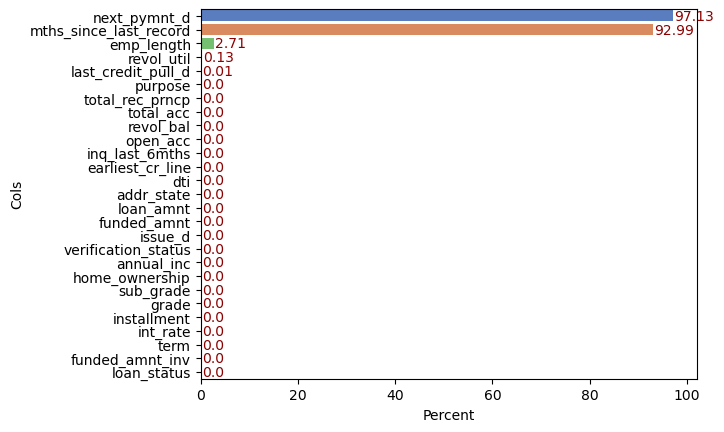

In [44]:
# Load percentage of null values for each columns
list_of_null_perc = df4.isnull().sum()/len(df4)*100 # list of null percentage of each column
list_of_cols= df4.columns

# Create dataframe of columns are their percentage of null values
df_perc = pd.DataFrame(list_of_null_perc, list_of_cols).reset_index().rename(columns={'index':'Cols', 0:'Percent'})
df_perc = df_perc.sort_values(by='Percent',ascending=False)

# Plot the dataframe
ax = sns.barplot(df_perc, x='Percent', y='Cols', hue='Cols', palette="muted")
# Add values to each bar
for bar in ax.patches:
    plt.text(bar.get_width()+0.3, bar.get_y()+0.7,
             round((bar.get_width()), 2),
             fontsize = 10,
             color ='darkred')
plt.show()

In [46]:
# Find columns with null percentage >= 90
cols_high_perc_of_null_val = df4.columns[df4.isnull().sum() > 90/100*len(df1)]
print (cols_high_perc_of_null_val)

Index(['mths_since_last_record', 'next_pymnt_d'], dtype='object')


In [47]:
# Dropping columns with percentage of null values higher than 90%
print ('Shape before dropping:', df4.shape)
df5 = df4.drop(columns=cols_high_perc_of_null_val)
print ('Shape after dropping):', df5.shape)

Shape before dropping: (39717, 27)
Shape after dropping): (39717, 25)


### 1.2.6 Check and convert inappropriate datatypes

In [48]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            39717 non-null  int64  
 1   funded_amnt          39717 non-null  int64  
 2   funded_amnt_inv      39717 non-null  float64
 3   term                 39717 non-null  object 
 4   int_rate             39717 non-null  object 
 5   installment          39717 non-null  float64
 6   grade                39717 non-null  object 
 7   sub_grade            39717 non-null  object 
 8   emp_length           38642 non-null  object 
 9   home_ownership       39717 non-null  object 
 10  annual_inc           39717 non-null  float64
 11  verification_status  39717 non-null  object 
 12  issue_d              39717 non-null  object 
 13  loan_status          39717 non-null  object 
 14  purpose              39717 non-null  object 
 15  addr_state           39717 non-null 

### Infernces from the and cleaning up: The data has 39717 rows and 111 columns
- 54 Empty Columns
- 9 columns with only 1 unique value across rows 
- 14 unnecessary fields
- 4 fields with value 0 in most rows and some outliers
- 2 fields with more than 90% null values 

What to do? ==> Drop all the above columns

After cleaning up, the dataframe has 25 columns left.


In [49]:
# Understand each attribute
df5.head()

loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  installment  \
0       5000         5000           4975.0   36 months   10.65%       162.87   
1       2500         2500           2500.0   60 months   15.27%        59.83   
2       2400         2400           2400.0   36 months   15.96%        84.33   
3      10000        10000          10000.0   36 months   13.49%       339.31   
4       3000         3000           3000.0   60 months   12.69%        67.79   

  grade sub_grade emp_length home_ownership  ...  addr_state    dti  \
0     B        B2  10+ years           RENT  ...          AZ  27.65   
1     C        C4   < 1 year           RENT  ...          GA   1.00   
2     C        C5  10+ years           RENT  ...          IL   8.72   
3     C        C1  10+ years           RENT  ...          CA  20.00   
4     B        B5     1 year           RENT  ...          OR  17.94   

  earliest_cr_line inq_last_6mths open_acc revol_bal  revol_util total_acc  \
0           Jan-85              1        3     13648      83.70%         9   
1           Apr-99              5        3      1687       9.40%         4   
2           Nov-01              2        2      2956      98.50%        10   
3           Feb-96              1       10      5598         21%        37   
4           Jan-96              0       15     27783      53.90%        38   

   total_rec_prncp  last_credit_pull_d  
0          5000.00              May-16  
1           456.46              Sep-13  
2          2400.00              May-16  
3         10000.00              Apr-16  
4          2475.94              May-16  

[5 rows x 25 columns]

#### Columns should be converted:
- 'int_rate' should be of 'float64'
- 'issue_d' should be of 'Datetime'
- 'earliest_cr_line' shoud be of 'Datetime'
- 'revol_util' should be of 'float64'
- 'last_credit_pull_d' should be of 'Datetime'

dtype('O')

In [55]:
#Convert 'int_rate' to 'float64'
print ('Data type before: ', df5.int_rate.dtype)
df5.int_rate = df5.int_rate.apply(lambda x: float(str(x).rstrip('%')))
print ('Data type after: ', df5.int_rate.dtype)

Data type before:  object
Data type after:  float64


In [56]:
#Convert 'issue_d' to 'Datetime'
print ('Data type before: ', df5.issue_d.dtype)
df5.issue_d = df5['issue_d'].apply(lambda x: pd.to_datetime(x, format='%b-%y'))
print ('Data type after: ', df5.issue_d.dtype)

Data type before:  object
Data type after:  datetime64[ns]


In [57]:
#Convert 'earliest_cr_line' to 'Datetime'
print ('Data type before: ', df5.earliest_cr_line.dtype)
df5.earliest_cr_line = df5.earliest_cr_line.apply(lambda x: pd.to_datetime(x, format='%b-%y'))
print ('Data type after: ', df5.earliest_cr_line.dtype)

Data type before:  object
Data type after:  datetime64[ns]


In [58]:
#Convert 'revol_util' to 'float64'
print ('Data type before: ', df5.revol_util.dtype)
df5.revol_util = df5.revol_util.apply(lambda x: float(str(x).rstrip('%')))
print ('Data type after: ', df5.revol_util.dtype)

Data type before:  object
Data type after:  float64


In [59]:
#Convert 'last_credit_pull_d' to 'Datetime'
print ('Data type before: ', df5.last_credit_pull_d.dtype)
df5.last_credit_pull_d = df5.last_credit_pull_d.apply(lambda x: pd.to_datetime(x, format='%b-%y'))
print ('Data type after: ', df5.last_credit_pull_d.dtype)

Data type before:  object
Data type after:  datetime64[ns]


### 1.2.7 Adding a TARGET attribute 'has_defaulted' (value of 0/1)
We should add a derived metric, also a target attribute named 'has_defaulted' to show whether the customer has defaulted

In [60]:
df5['has_defaulted'] = df5['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
df_loan = df5

In [62]:
df_loan.head(2)

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0       5000         5000           4975.0   36 months     10.65       162.87   
1       2500         2500           2500.0   60 months     15.27        59.83   

  grade sub_grade emp_length home_ownership  ...    dti earliest_cr_line  \
0     B        B2  10+ years           RENT  ...  27.65       1985-01-01   
1     C        C4   < 1 year           RENT  ...   1.00       1999-04-01   

  inq_last_6mths open_acc revol_bal revol_util  total_acc total_rec_prncp  \
0              1        3     13648       83.7          9         5000.00   
1              5        3      1687        9.4          4          456.46   

   last_credit_pull_d  has_defaulted  
0          2016-05-01              0  
1          2013-09-01              1  

[2 rows x 26 columns]

# 3. EXPLORATORY DATA ANALYSIS:

## 3.1 Categorical Variables:
### Unordered CATEGORICAL variables:
- term: 36 months / 60 months
- grade: A, B, C, D, E, F, and G
- sub_grade: A1, A2, A3, A4, A5, B1....
- home_ownership: RENT, MORTGAGE, OWN, OTHER & NONE.
- verification_status: Not Verified, Verified & Source Verified
- loan_status: Fully Paid, Charged Off & Current
- purpose: debt_consolidation, credit_card, home_improvement....
- addr_state: CA, NY, FL, TX, NJ...

### Ordered CATEGORICAL variables:
- emp_length: < 1 year, 2 years,...., 9 years, 10+ years
- inq_last_6mths (The number of inquiries in past 6 months): 0-8

## 3.2 Datetime Variabales:
- issue_d: The month which the loan was funded
- earliest_cr_line: The month the borrower's earliest reported credit line was opened
- last_credit_pull_d: The most recent month LC pulled credit for this loan

## 3.3 Quantitative Variabales
- loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- funded_amnt: The total amount committed to that loan at that point in time.
- funded_amnt_inv - The total amount committed by investors for that loan at that point in time.
- int_rate: Interest Rate on the loan
- installment: The monthly payment owed by the borrower if the loan originates.
- annual_inc: The self-reported annual income provided by the borrower during registration.
- dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- total_rec_prncp:  Principal received to date
- revol_bal: Total credit revolving balance
- revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- total_acc: The total number of credit lines currently in the borrower's credit file
- open_acc: The number of open credit lines in the borrower's credit file.

## 3.1 CATEGORICAL VARIABLES

### 3.1.1 Univariate Analysis

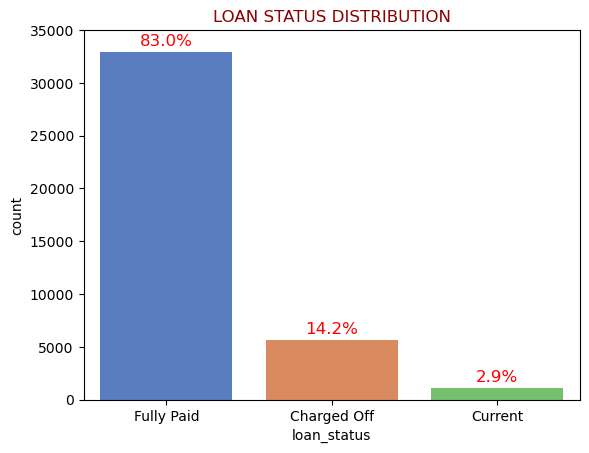

In [201]:
# Investigate the distribution of the attribute 'loan_status'

ax = sns.barplot(df_loan.loan_status.value_counts().reset_index(),x='loan_status', y='count', hue='loan_status', palette='muted')

# Annotate counts on the bars
total = len(df_loan.has_defaulted)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 1000, # vertical position of the annotation
            percentage, 
            ha="center", 
            va="center", 
            fontsize=12, 
            color='red')
plt.ylim(0, 35000)
plt.title('LOAN STATUS DISTRIBUTION', color='darkred')
plt.show()

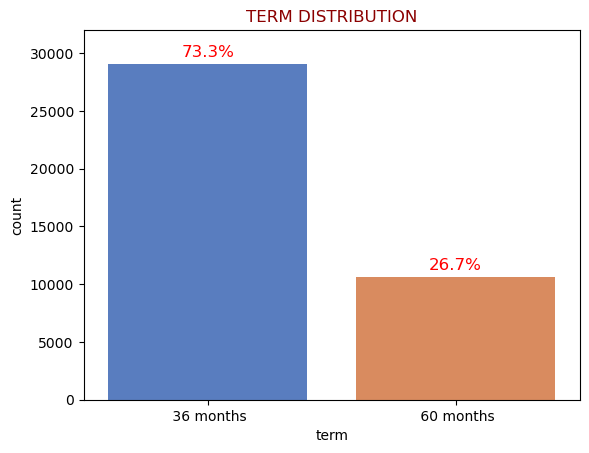

In [68]:
# Investigate the distribution of the attribute 'term'

ax = sns.barplot(df_loan.term.value_counts().reset_index(),x='term', y='count', hue='term', palette='muted')

# Annotate counts on the bars
total = len(df_loan.term)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 1000, # vertical position of the annotation
            percentage, 
            ha="center", 
            va="center", 
            fontsize=12, 
            color='red')
plt.ylim(0, 32000)
plt.title('TERM DISTRIBUTION', color='darkred')
plt.show()

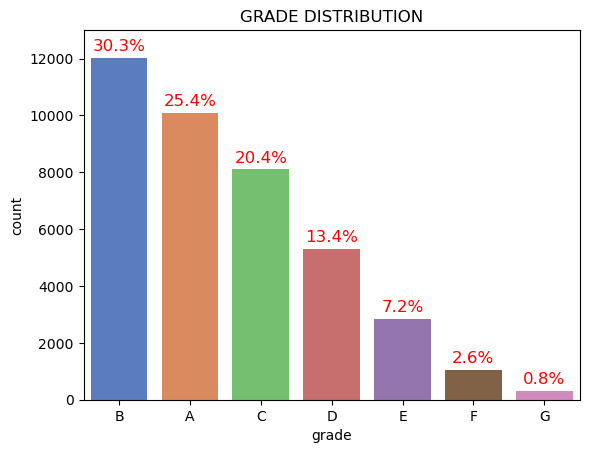

In [75]:
# Investigate distribution of the attribute 'grade'
ax = sns.barplot(df_loan.grade.value_counts().reset_index(),x='grade', y='count', hue='grade', palette='muted')

# Annotate counts on the bars
total = len(df_loan.grade)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 400, # vertical position of the annotation
            percentage, 
            ha="center", 
            va="center", 
            fontsize=12, 
            color='red')
plt.ylim(0, 13000)
plt.title('GRADE DISTRIBUTION')
plt.show()

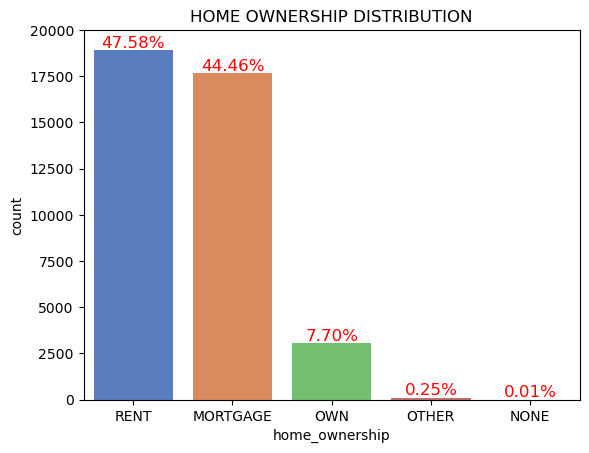

In [78]:
# Investigate the distribution of the attribute 'home_ownership'
ax = sns.barplot(df_loan.home_ownership.value_counts().reset_index(),x='home_ownership', y='count', hue='home_ownership', palette='muted')

# Annotate counts on the bars
total = len(df_loan.home_ownership)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.2f}%"  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 400, # vertical position of the annotation
            percentage, 
            ha="center", 
            va="center", 
            fontsize=12, 
            color='red')
    
plt.ylim(0, 20000)
plt.title('HOME OWNERSHIP DISTRIBUTION')
# Show the plot
plt.show()

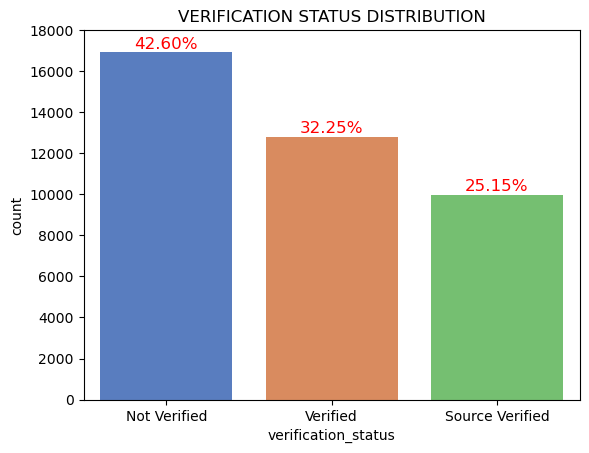

In [357]:
# Investigate the attribute 'verification_status'
ax = sns.barplot(df_loan.verification_status.value_counts().reset_index(),x='verification_status', y='count', hue='verification_status', palette='muted')
# Annotate counts on the bars
total = len(df_loan.verification_status)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.2f}%"  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 400, # vertical position of the annotation
            percentage, 
            ha="center", 
            va="center", 
            fontsize=12, 
            color='red')
    
plt.ylim(0, 18000)
plt.title('VERIFICATION STATUS DISTRIBUTION')
# Show the plot
plt.show()

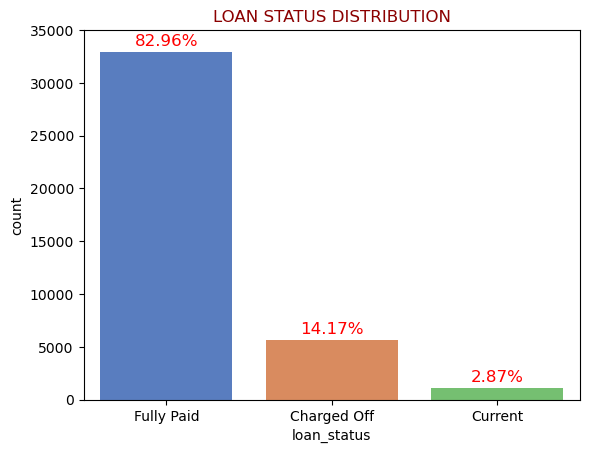

In [79]:
# Investigate the distribution of the attribute 'loan_status'
ax = sns.barplot(df_loan.loan_status.value_counts().reset_index(),x='loan_status', y='count', hue='loan_status', palette='muted')

# Annotate counts on the bars
total = len(df_loan.loan_status)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.2f}%"  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 1000, # vertical position of the annotation
            percentage, 
            ha="center", 
            va="center", 
            fontsize=12, 
            color='red')
plt.ylim(0, 35000)
plt.title('LOAN STATUS DISTRIBUTION', color='darkred')
# Show the plot
plt.show()

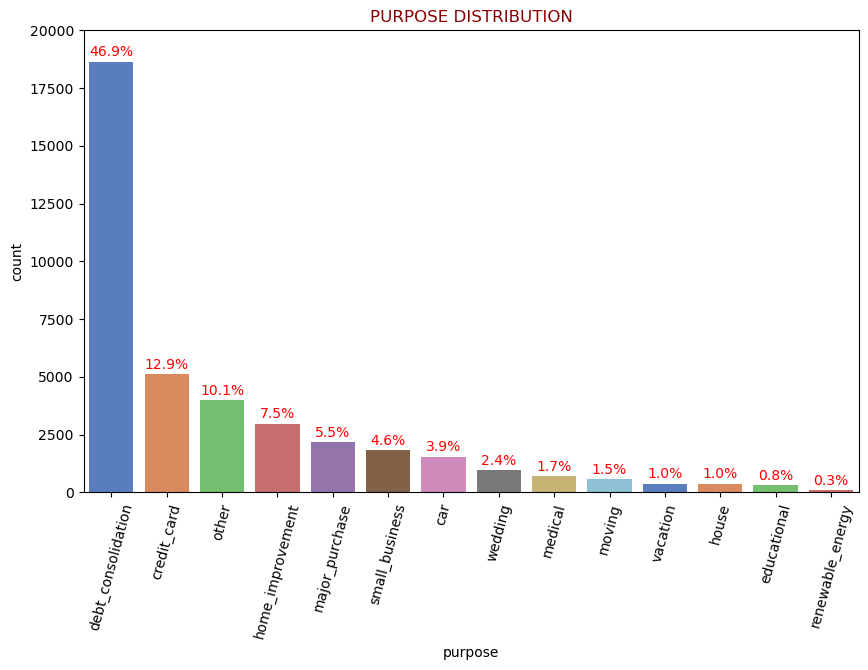

In [80]:
# Investigate the distribution of the attribute 'purpose'
plt.figure(figsize=(10,6))
ax = sns.barplot(df_loan.purpose.value_counts().reset_index(),x='purpose', y='count', hue='purpose', palette='muted')

# Annotate counts on the bars
total = len(df_loan.purpose)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 400, 
            percentage, 
            ha="center", 
            va="center", 
            fontsize=10, 
            color='red')
plt.ylim(0, 20000)
plt.title('PURPOSE DISTRIBUTION', color='darkred')
plt.xticks(rotation=75)
# Show the plot
plt.show()

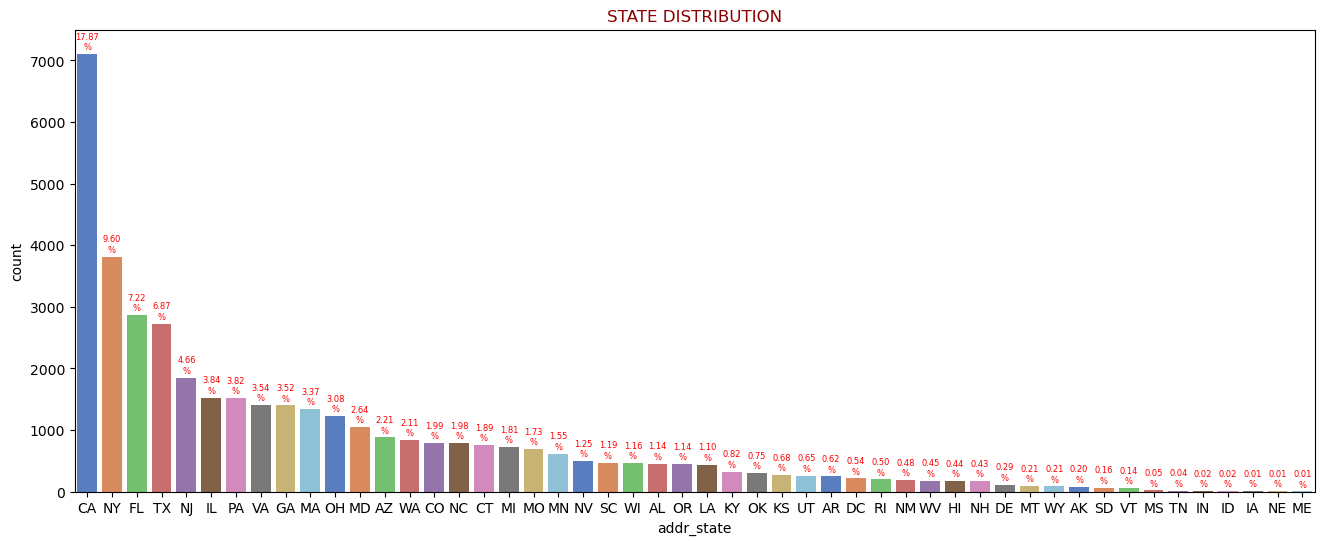

In [81]:
# Investigate the attribute 'addr_state'
plt.figure(figsize=(16,6))
ax = sns.barplot(df_loan.addr_state.value_counts().reset_index(),x='addr_state', y='count', hue='addr_state', palette='muted')

# Annotate counts on the bars
total = len(df_loan.addr_state)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.2f}\n%"  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 200, 
            percentage, 
            ha="center", 
            va="center", 
            fontsize=6, 
            color='red')
plt.ylim(0, 7500)
plt.title('STATE DISTRIBUTION', color='darkred')

plt.show()

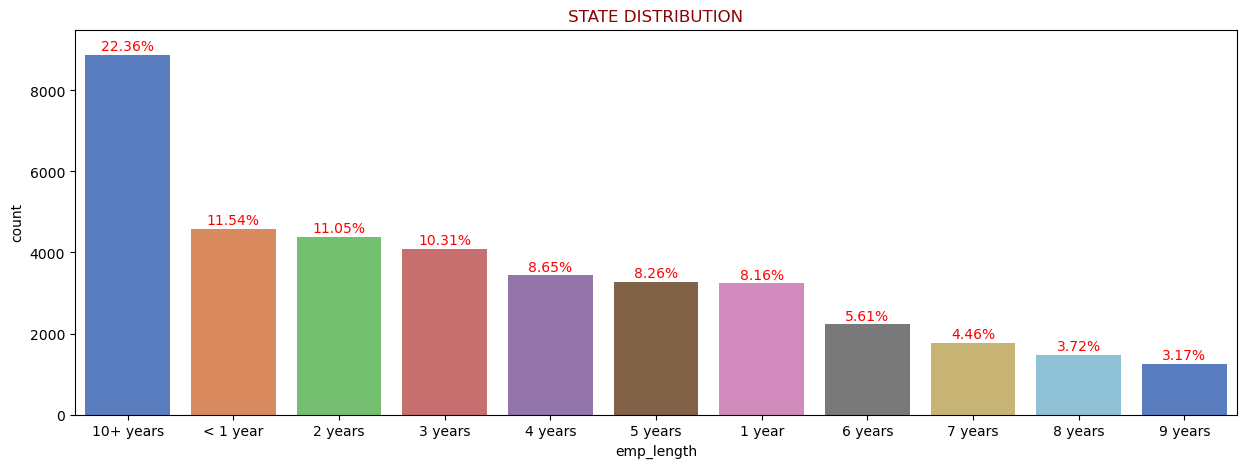

In [361]:
# Investigate the attribute 'emp_length'
plt.figure(figsize=(15,5))
ax = sns.barplot(df_loan.emp_length.value_counts().reset_index(),x='emp_length', y='count', hue='emp_length', palette='muted')

# Annotate counts on the bars
total = len(df_loan.emp_length)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.2f}%"  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 200, 
            percentage, 
            ha="center", 
            va="center", 
            fontsize=10, 
            color='red')
plt.ylim(0, 9500)
plt.title('STATE DISTRIBUTION', color='darkred')
# plt.xticks(rotation=75)
# Show the plot
plt.show()

## # Initial observations:
- 'Term' attribute: more people loan for 36 months (73.3%) than those for 60 months (26.7%)
- 'grade' attribute: most borrowers are at high grades (B: 30.3%, A: 25.4% and C: 20.4%)
- 'home_ownership'attribute: most people do not own a house. They are renting or their houses are under mortgage.
- 'verification_status' attribute: 42.6% of them are not verified
- 'loan_status' attribute: most of the borrowers (82.96) could pay their loan.
- 'purpose' atttribute: most people (46.7%) borrowed to pay other debts
- 'addr_state' atttribute: most people live in California (17.87%), Newyork (9.6%) and Florida (7.22%)

### 3.1.2 Bivariate Analysis - Understanding the relationship between each of the above attribute and the attribute 'has_defaulted'

#### The relationship between 'term' and the attribute 'has_defaulted' 

Pivot table: 
 term           36 months  60 months
has_defaulted      11.09       22.6


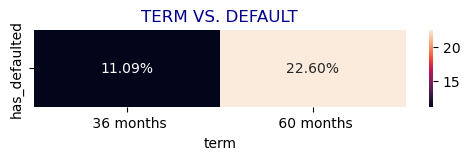

In [84]:
# the relationship between 'term' and the attribute 'has_defaulted' 
pv_term_default = pd.pivot_table(df_loan, columns='term', values= 'has_defaulted' ,aggfunc='mean').apply(lambda  x: round(x*100, 2))
print ('Pivot table: \n', pv_term_default)
plt.figure(figsize=(6,1))
sns.heatmap(pv_term_default, annot=True, fmt=".2f")
# add the character '%' after the numbers
for text in plt.gca().texts:
    text.set_text(f"{text.get_text()}%")
plt.title('TERM VS. DEFAULT', fontdict={'size': 12, 'color':'darkblue'})
plt.show()

#### The relationship between 'grade' and the attribute 'has_defaulted' 

Pivot table: 
 grade             A      B      C      D      E      F      G
has_defaulted  5.97  11.86  16.63  21.07  25.16  30.41  31.96


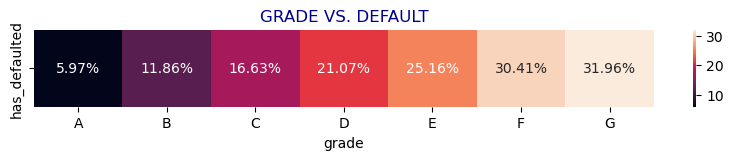

In [86]:
# The relationship between 'grade' and the attribute 'has_defaulted'
# create pivot table
pv_grade_default = pd.pivot_table(df_loan, columns='grade', values= 'has_defaulted' ,aggfunc='mean').apply(lambda  x: round(x*100, 2))
print ('Pivot table: \n', pv_grade_default)

plt.figure(figsize=(10,1))
sns.heatmap(pv_grade_default, annot=True, fmt=".2f")

# add the character '%' after the numbers
for text in plt.gca().texts:
    text.set_text(f"{text.get_text()}%")
plt.title('GRADE VS. DEFAULT', fontdict={'size': 12, 'color':'darkblue'})
plt.show()

#### The relationship between 'home_ownership' and the attribute 'has_defaulted' 

Pivot table: 
 home_ownership  MORTGAGE  NONE  OTHER    OWN   RENT
has_defaulted      13.18   0.0  18.37  14.49  15.02


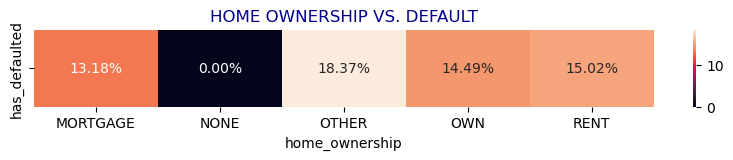

In [87]:
# The relationship between 'home_ownership' and the attribute 'has_defaulted' 
# create pivot table
pv_home_default = pd.pivot_table(df_loan, columns='home_ownership', values= 'has_defaulted' ,aggfunc='mean').apply(lambda  x: round(x*100, 2))
print ('Pivot table: \n', pv_home_default)

plt.figure(figsize=(10,1))
sns.heatmap(pv_home_default, annot=True, fmt=".2f")

# add the character '%' after the numbers
for text in plt.gca().texts:
    text.set_text(f"{text.get_text()}%")
plt.title('HOME OWNERSHIP VS. DEFAULT', fontdict={'size': 12, 'color':'darkblue'})
plt.show()

#### The relationship between 'verification_status' and the attribute 'has_defaulted' 

Pivot table: 
 verification_status  Not Verified  Source Verified  Verified
has_defaulted               12.66            14.36     16.01


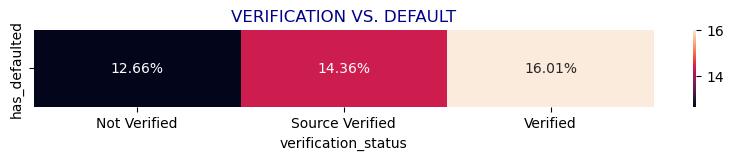

In [88]:
# The relationship between 'verification_status' and the attribute 'has_defaulted' 
# create pivot table
pv_veri_stat_default = pd.pivot_table(df_loan, columns='verification_status', values= 'has_defaulted' ,aggfunc='mean').apply(lambda  x: round(x*100, 2))
print ('Pivot table: \n', pv_veri_stat_default)
plt.figure(figsize=(10,1))

# plot a heatmap
sns.heatmap(pv_veri_stat_default, annot=True, fmt=".2f")

# add the character '%' after the numbers
for text in plt.gca().texts:
    text.set_text(f"{text.get_text()}%")
plt.title('VERIFICATION VS. DEFAULT', fontdict={'size': 12, 'color':'darkblue'})
plt.show()

#### The relationship between 'purpose' and the attribute 'has_defaulted' 

Pivot table: 
 purpose          car  credit_card  debt_consolidation  educational  \
has_defaulted  10.33        10.57               14.84        17.23   

purpose        home_improvement  house  major_purchase  medical  moving  \
has_defaulted             11.66  15.49           10.15     15.3   15.78   

purpose        other  renewable_energy  small_business  vacation  wedding  
has_defaulted  15.85             18.45           25.98     13.91    10.14  


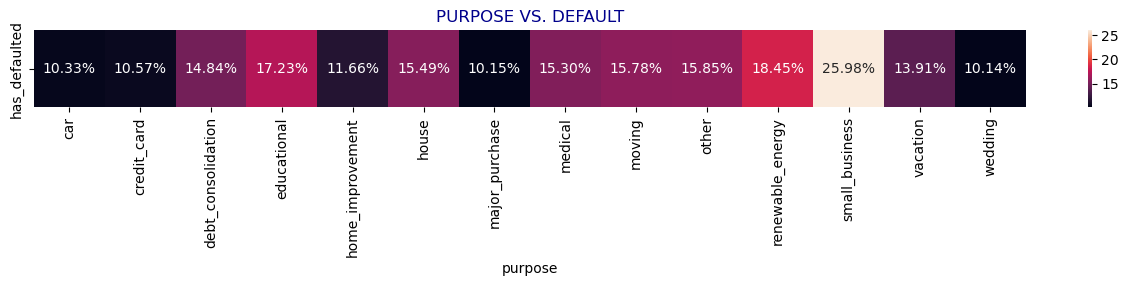

In [90]:
# The relationship between 'purpose' and the attribute 'has_defaulted' 
# create pivot table
pv_purpose_default = pd.pivot_table(df_loan, columns='purpose', values= 'has_defaulted' ,aggfunc='mean').apply(lambda  x: round(x*100, 2))
print ('Pivot table: \n', pv_purpose_default)

plt.figure(figsize=(16,1))

# plot the heatmap
sns.heatmap(pv_purpose_default, annot=True, fmt=".2f")

# add the character '%' after the numbers
for text in plt.gca().texts:
    text.set_text(f"{text.get_text()}%")
plt.title('PURPOSE VS. DEFAULT', fontdict={'size': 12, 'color':'darkblue'})
plt.show()

#### The relationship between 'addr_state' and the attribute 'has_defaulted' 

Pivot table: 
 addr_state        AK     AL     AR     AZ     CA     CO     CT    DC     DE  \
has_defaulted  18.75  11.95  11.02  13.99  15.85  12.37  12.52  7.01  10.53   

addr_state        FL  ...     SD     TN     TX    UT     VA     VT     WA  \
has_defaulted  17.59  ...  18.75  11.76  11.59  15.5  12.58  11.11  15.12   

addr_state       WI     WV    WY  
has_defaulted  13.7  11.86  4.82  

[1 rows x 50 columns]


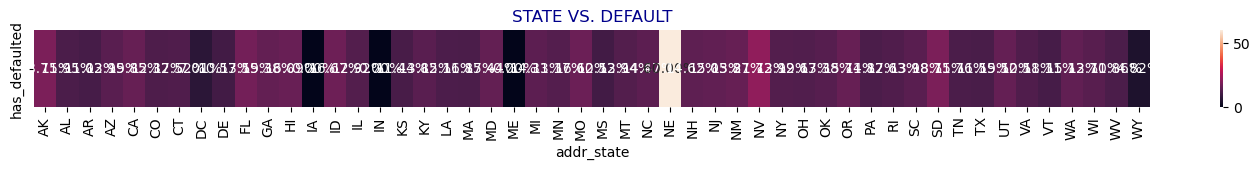

In [92]:
# The relationship between 'addr_state' and the attribute 'has_defaulted' 
# create a pivot table
pv_addr_state_default = pd.pivot_table(df_loan, columns='addr_state', values= 'has_defaulted' ,aggfunc='mean').apply(lambda  x: round(x*100, 2))
print ('Pivot table: \n', pv_addr_state_default)

plt.figure(figsize=(18,1))
# plot the heatmap
sns.heatmap(pv_addr_state_default, annot=True, fmt=".2f")

# add the character '%' after the numbers
for text in plt.gca().texts:
    text.set_text(f"{text.get_text()}%")
plt.title('STATE VS. DEFAULT', fontdict={'size': 12, 'color':'darkblue'})
plt.show()

#### The relationship between 'emp_length' and the attribute 'has_defaulted' 

Pivot table: 
 addr_state        AK     AL     AR     AZ     CA     CO     CT    DC     DE  \
has_defaulted  18.75  11.95  11.02  13.99  15.85  12.37  12.52  7.01  10.53   

addr_state        FL  ...     SD     TN     TX    UT     VA     VT     WA  \
has_defaulted  17.59  ...  18.75  11.76  11.59  15.5  12.58  11.11  15.12   

addr_state       WI     WV    WY  
has_defaulted  13.7  11.86  4.82  

[1 rows x 50 columns]


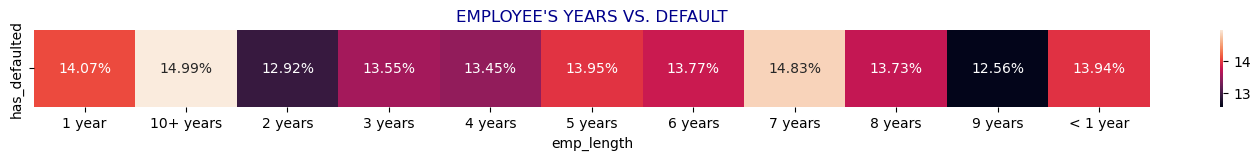

In [95]:
# The relationship between 'addr_state' and the attribute 'has_defaulted' 
# create a pivot table
pv_emp_length_default = pd.pivot_table(df_loan, columns='emp_length', values= 'has_defaulted' ,aggfunc='mean').apply(lambda  x: round(x*100, 2))
print ('Pivot table: \n', pv_addr_state_default)

plt.figure(figsize=(18,1))

# plot the heatmap
sns.heatmap(pv_emp_length_default, annot=True, fmt=".2f")

# add the character '%' after the numbers
for text in plt.gca().texts:
    text.set_text(f"{text.get_text()}%")
plt.title("EMPLOYEE'S YEARS VS. DEFAULT", fontdict={'size': 12, 'color':'darkblue'})
plt.show()


#### The relationship between 'inq_last_6mths ' and the attribute 'has_defaulted' 

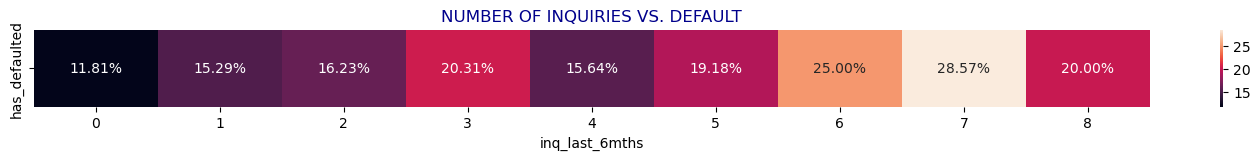

In [101]:
# The relationship between 'inq_last_6mths ' and the attribute 'has_defaulted' 
# create a pivot table
pv_inq_last_6mths_default = pd.pivot_table(df_loan, columns='inq_last_6mths', values= 'has_defaulted' ,aggfunc='mean').apply(lambda  x: round(x*100, 2))

plt.figure(figsize=(18,1))

# plot the heatmap
sns.heatmap(pv_inq_last_6mths_default, annot=True, fmt=".2f")

# add the character '%' after the numbers
for text in plt.gca().texts:
    text.set_text(f"{text.get_text()}%")
plt.title("NUMBER OF INQUIRIES VS. DEFAULT", fontdict={'size': 12, 'color':'darkblue'})
plt.show()


## General thoughts about categorical variables:

- Term: the longer the loan is, the more possibility of default. Specifically, the default rate of 60 months is 22.60%, and of 36 months is 11.09%
- grade: borrowers graded from D(21.07%) to G (31.96%) have higher probability of defaulting
- home_ownership: home ownership doesn't seem to influence much on the rate of default (13.18-15.02%)
- verification_status: unverified borrowers have less probability of defaulting ==> THIS IS SO STRANGE. WE MUST INVESTIGATE THE PROCESS OF VERIFYING
- purpose: borrowers running small businesses have the highest probability of default
- addr_state: borrowers from NE-Nebraska have the highest probability of default
- emp_length: emp_length does not influence much on the default rate.
- inq_last_6mths: the more inquiries the higher probability of default it is (top 3: 6, 7 and 8)

## 3.2 Datetime variables:

### 3.2.1 Mean of loan by month across years

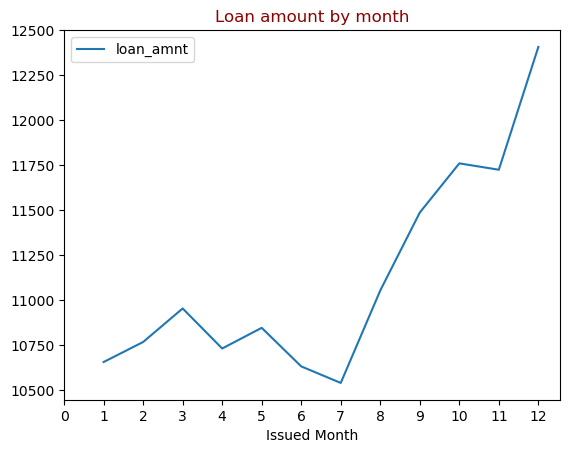

In [106]:
# Mean of loan by month across years
df_issue_d = df_loan.groupby(df_loan.issue_d.dt.month)[['loan_amnt']].mean() # mean of loan amount by month

# plot a line chart
df_issue_d.plot.line()

plt.title('Loan amount by month', color='darkred')
plt.xticks(ticks=range(0, 13, 1))
plt.xlabel('Issued Month')
plt.show()

### 3.2.1 Total of loan amount by year

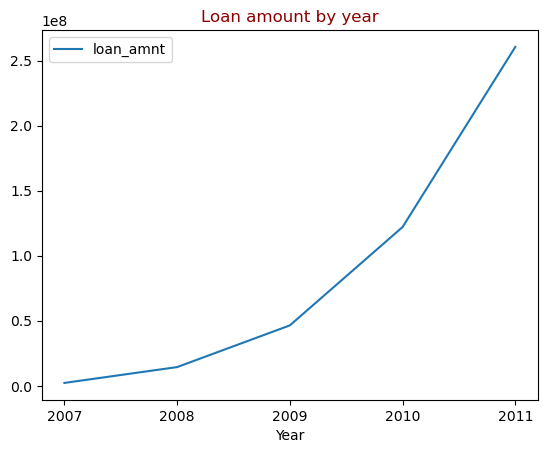

In [105]:
# Total of loan amount by year
df_issue_y = df_loan.groupby(df_loan.issue_d.dt.year)[['loan_amnt']].sum()

# plot the line chart 
df_issue_y.plot.line()

plt.title('Loan amount by year', color='darkred')
plt.xticks(ticks=range(2007,2012,1))
plt.xlabel('Year')
plt.show()

## Inferences on datetime variables:
- Total loan amount increases by year, highest in 2011
- Loan amount is higher in the second half of the year than the other

## 3.3 Quantitative Variables:

### 3.3.0 Overview

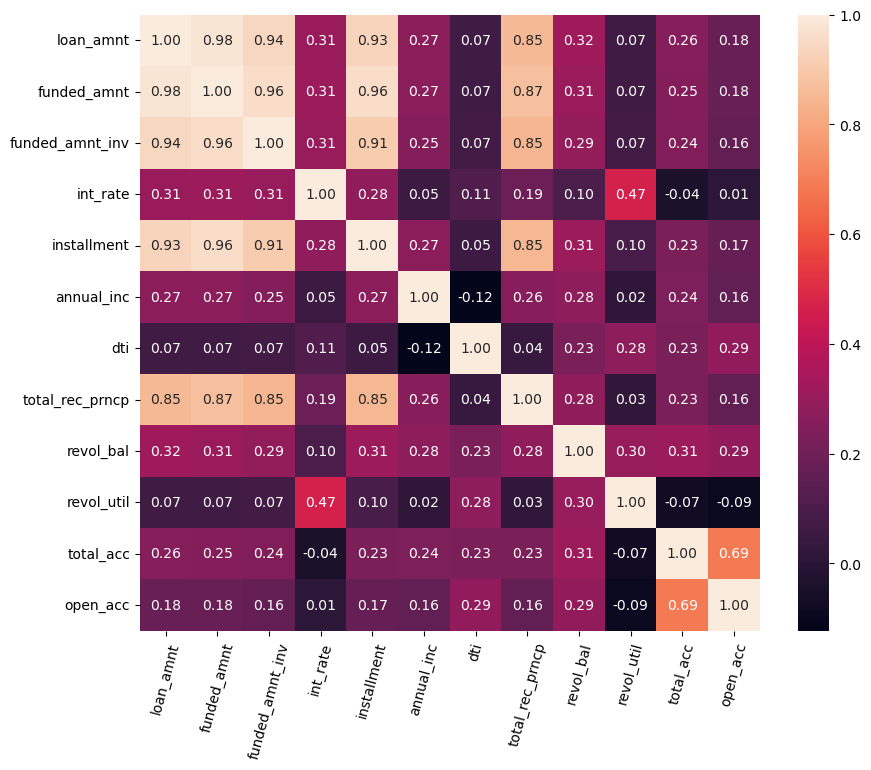

In [109]:
# Correlations among these attributes
plt.figure(figsize=(10, 8))
sns.heatmap(df_loan[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 
                    'installment', 'annual_inc', 'dti', 'total_rec_prncp', 
                    'revol_bal', 'revol_util', 'total_acc', 'open_acc']].corr(), 
        fmt='0.2f', 
        annot=True)

plt.xticks(rotation=75) # rotate the xtick for readability
plt.show()


### 3.3.1 Univariate Analysis on quantitative variables

1 >>> Investigate the distribution of the attribute: loan_amnt
count    39717.000000
mean     11219.443815
std       7456.670694
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

** Number of outliers (> 29250.0): 1230, which is 3.1%


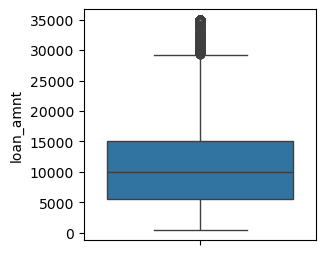

2 >>> Investigate the distribution of the attribute: funded_amnt
count    39717.000000
mean     10947.713196
std       7187.238670
min        500.000000
25%       5400.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: funded_amnt, dtype: float64

** Number of outliers (> 29400.0): 1226, which is 3.09%


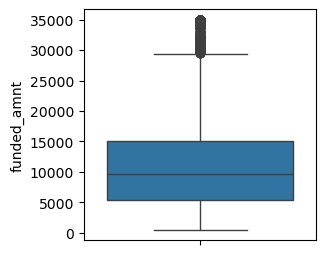

3 >>> Investigate the distribution of the attribute: funded_amnt_inv
count    39717.000000
mean     10397.448868
std       7128.450439
min          0.000000
25%       5000.000000
50%       8975.000000
75%      14400.000000
max      35000.000000
Name: funded_amnt_inv, dtype: float64

** Number of outliers (> 28500.0): 1269, which is 3.2%


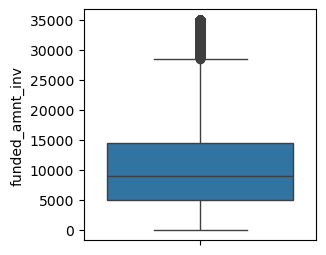

4 >>> Investigate the distribution of the attribute: int_rate
count    39717.000000
mean        12.021177
std          3.724825
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: int_rate, dtype: float64

** Number of outliers (> 22.6): 39717, which is 100.0%


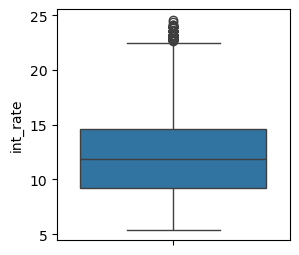

5 >>> Investigate the distribution of the attribute: installment
count    39717.000000
mean       324.561922
std        208.874874
min         15.690000
25%        167.020000
50%        280.220000
75%        430.780000
max       1305.190000
Name: installment, dtype: float64

** Number of outliers (> 826.42): 39708, which is 99.98%


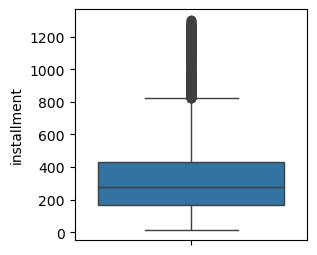

6 >>> Investigate the distribution of the attribute: annual_inc
count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

** Number of outliers (> 145144.0): 0, which is 0.0%


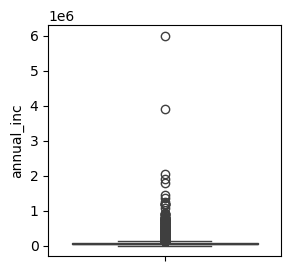

7 >>> Investigate the distribution of the attribute: dti
count    39717.000000
mean        13.315130
std          6.678594
min          0.000000
25%          8.170000
50%         13.400000
75%         18.600000
max         29.990000
Name: dti, dtype: float64

** Number of outliers (> 34.245000000000005): 39717, which is 100.0%


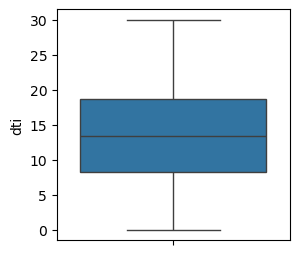

8 >>> Investigate the distribution of the attribute: total_rec_prncp
count    39717.000000
mean      9793.348813
std       7065.522127
min          0.000000
25%       4600.000000
50%       8000.000000
75%      13653.260000
max      35000.020000
Name: total_rec_prncp, dtype: float64

** Number of outliers (> 27233.15): 1462, which is 3.68%


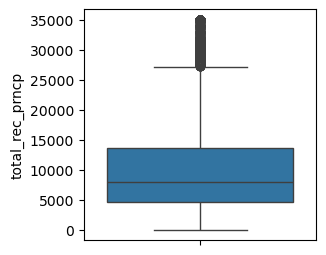

9 >>> Investigate the distribution of the attribute: revol_bal
count     39717.000000
mean      13382.528086
std       15885.016641
min           0.000000
25%        3703.000000
50%        8850.000000
75%       17058.000000
max      149588.000000
Name: revol_bal, dtype: float64

** Number of outliers (> 37090.5): 0, which is 0.0%


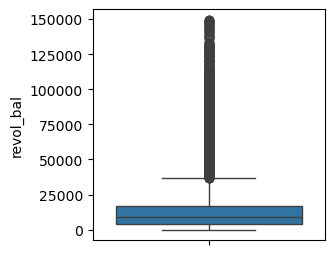

10 >>> Investigate the distribution of the attribute: revol_util
count    39667.000000
mean        48.832152
std         28.332634
min          0.000000
25%         25.400000
50%         49.300000
75%         72.400000
max         99.900000
Name: revol_util, dtype: float64

** Number of outliers (> 142.90000000000003): 39717, which is 100.0%


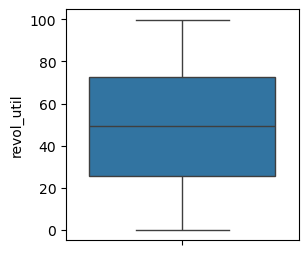

11 >>> Investigate the distribution of the attribute: total_acc
count    39717.000000
mean        22.088828
std         11.401709
min          2.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64

** Number of outliers (> 53.0): 39717, which is 100.0%


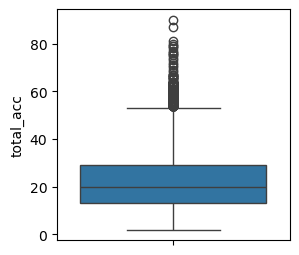

12 >>> Investigate the distribution of the attribute: open_acc
count    39717.000000
mean         9.294408
std          4.400282
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64

** Number of outliers (> 21.0): 39717, which is 100.0%


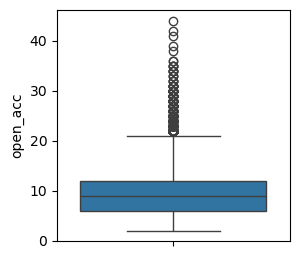

In [119]:
# Investigate the distribution of all the quantitative attrbutes
attribute_list = ['loan_amnt', 'funded_amnt','funded_amnt_inv',
                'int_rate', 'installment', 'annual_inc', 
                'dti', 'total_rec_prncp', 'revol_bal', 
                'revol_util', 'total_acc', 'open_acc'
                ]
attr_count = 1
# plot distribution boxplot for the above attributes 
for attr in attribute_list:
    print (attr_count ,'>>> Investigate the distribution of the attribute:', attr)

    #remove outliers
    print(df_loan[attr].describe())
    q1 = df_loan[attr].describe()['25%']
    q3 = df_loan[attr].describe()['75%']
    iqr =  q3 -q1
    highbound = q3 + 1.5*iqr  # determine the high boundary
    df_outliers = df_loan[df_loan.loan_amnt > highbound] #remove outliers

    # Print the number and percentage of outliers
    print ('\n** Number of outliers (> {}): {}, which is {}%'.format(highbound,len(df_outliers),round(len(df_outliers)/len(df_loan)*100, 2)))
    plt.figure(figsize=(3,3))

    #plot the chart
    sns.boxplot(df_loan[attr])
    plt.show()
    attr_count +=1

### 3.3.2 Bivariate Analysis:

Add a new column named 'defaulter' as a categorical variable (Yes/No)

In [120]:
# Add a new column 'defaulter' with values Yes/No 
df_loan['defaulter'] = df_loan.has_defaulted.apply(lambda x: 'Yes' if x == 1 else 'No')
df_loan.head(3)


loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0       5000         5000           4975.0   36 months     10.65       162.87   
1       2500         2500           2500.0   60 months     15.27        59.83   
2       2400         2400           2400.0   36 months     15.96        84.33   

  grade sub_grade emp_length home_ownership  ...  earliest_cr_line  \
0     B        B2  10+ years           RENT  ...        1985-01-01   
1     C        C4   < 1 year           RENT  ...        1999-04-01   
2     C        C5  10+ years           RENT  ...        2001-11-01   

  inq_last_6mths open_acc revol_bal revol_util total_acc  total_rec_prncp  \
0              1        3     13648       83.7         9          5000.00   
1              5        3      1687        9.4         4           456.46   
2              2        2      2956       98.5        10          2400.00   

  last_credit_pull_d  has_defaulted  defaulter  
0         2016-05-01              0         No  
1         2013-09-01              1        Yes  
2         2016-05-01              0         No  

[3 rows x 27 columns]

##### Analyze ralationship between quantitative variables and the number of defaulters

1. *** Ralationship between 'loan_amnt' and the number of defaulters' ***


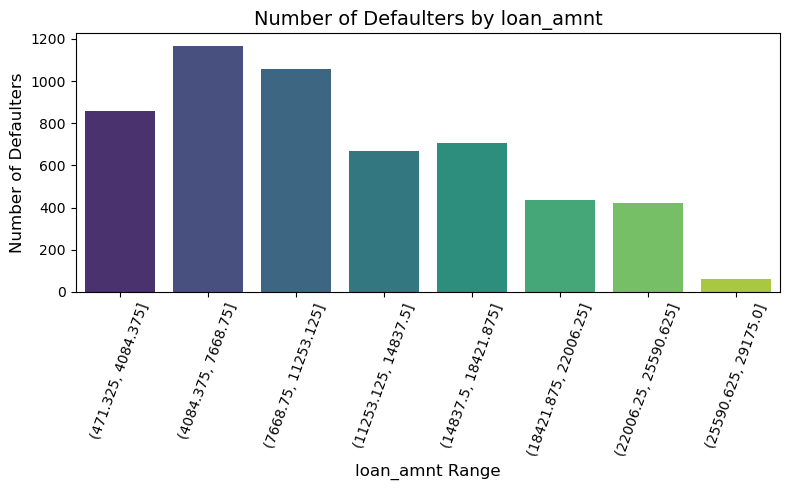

2. *** Ralationship between 'funded_amnt' and the number of defaulters' ***


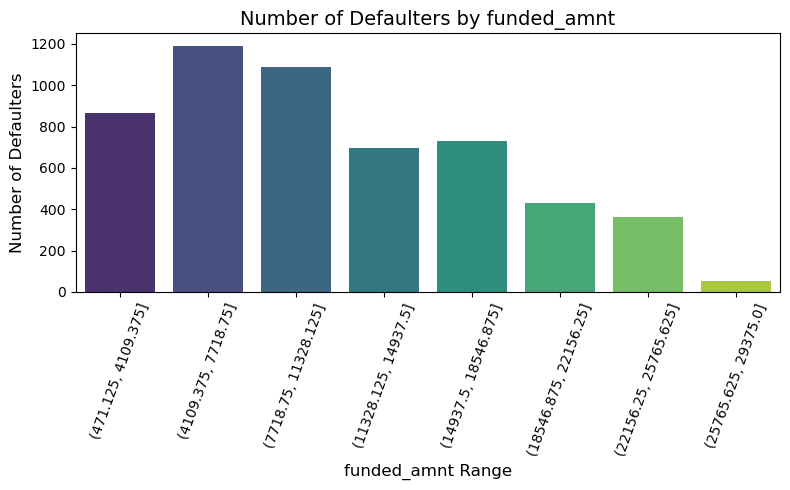

3. *** Ralationship between 'funded_amnt_inv' and the number of defaulters' ***


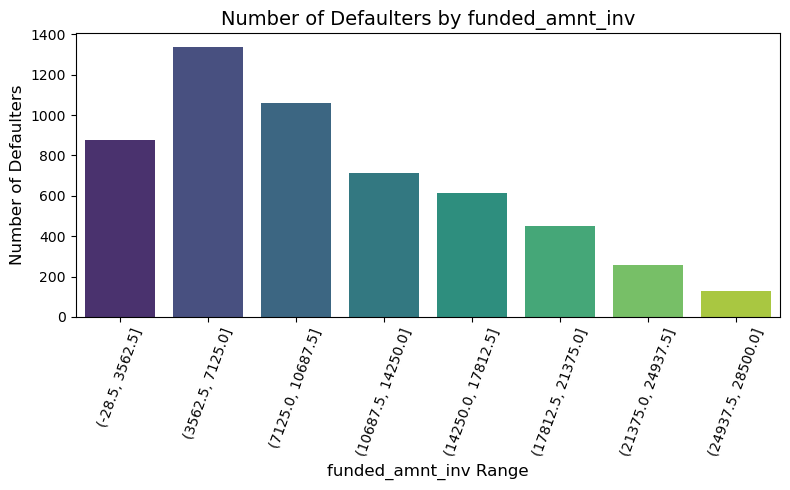

4. *** Ralationship between 'int_rate' and the number of defaulters' ***


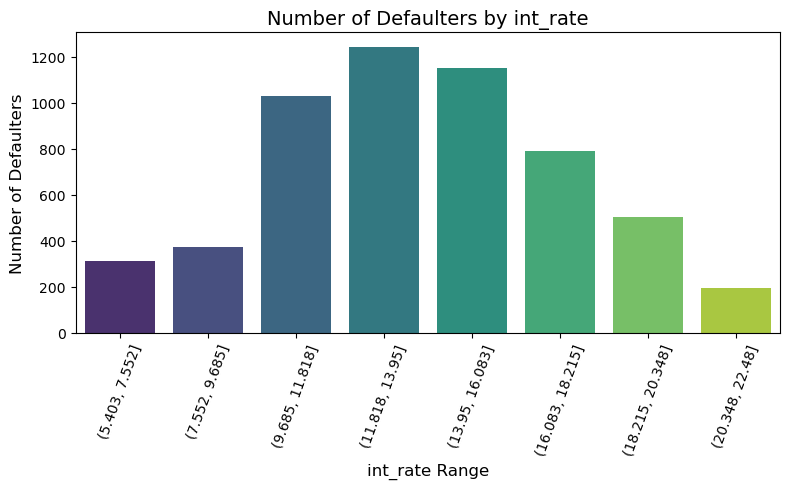

5. *** Ralationship between 'installment' and the number of defaulters' ***


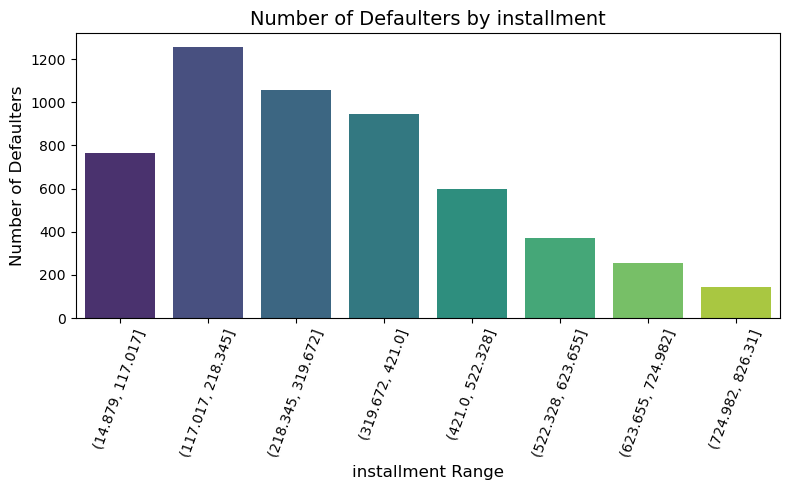

6. *** Ralationship between 'annual_inc' and the number of defaulters' ***


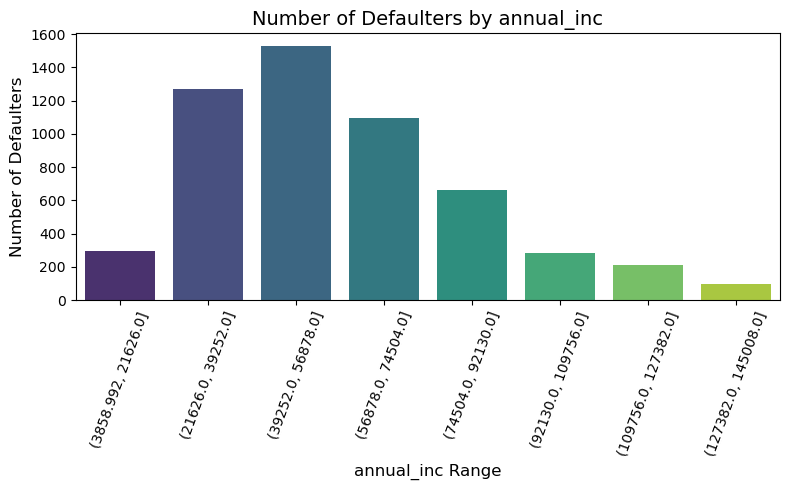

7. *** Ralationship between 'dti' and the number of defaulters' ***


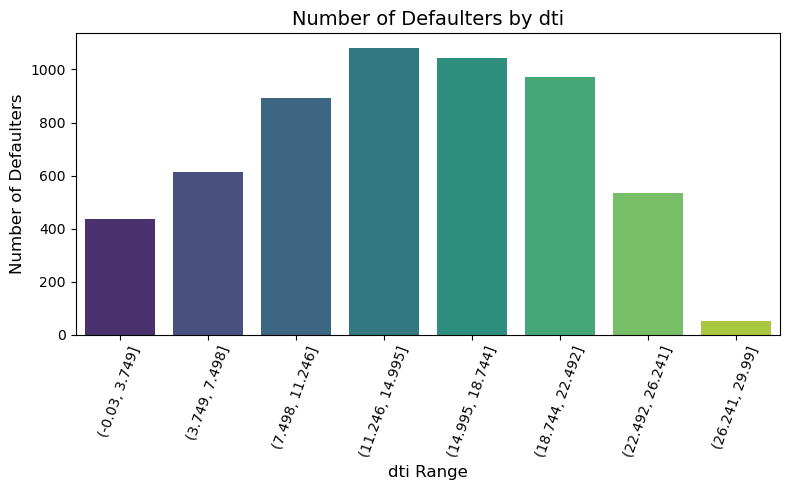

8. *** Ralationship between 'revol_util' and the number of defaulters' ***


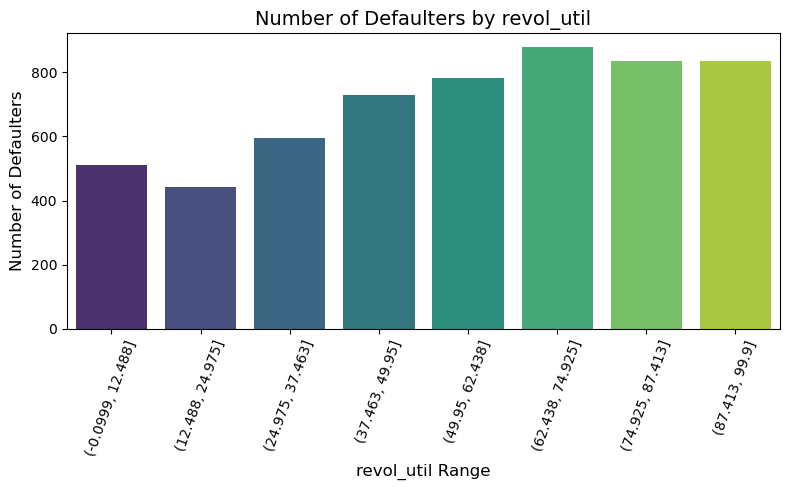

9. *** Ralationship between 'open_acc' and the number of defaulters' ***


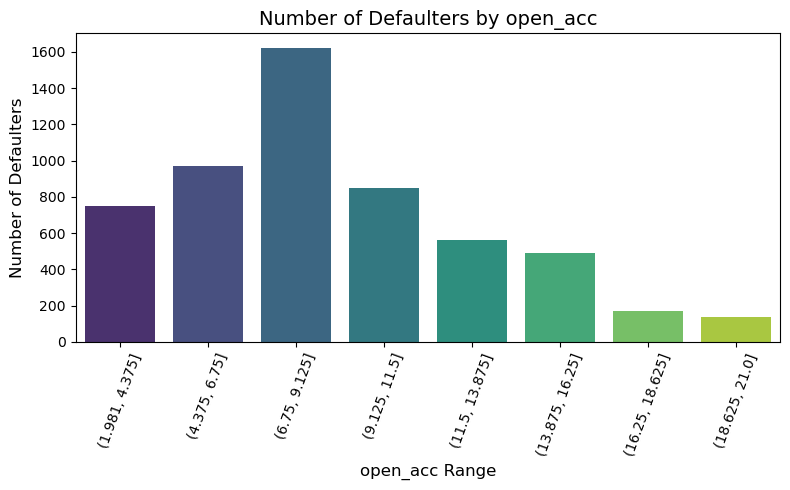

In [172]:
# This function is to remove outliers and return a new dataframe 
def remove_outliers(df: pd.DataFrame, field: str) -> pd.DataFrame:
    # Tính Q1 và Q3
    Q1 = df[field].quantile(0.25)
    Q3 = df[field].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine the higher and lower bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    cleaned_df = df[(df[field] >= lower_bound) & (df[field] <= upper_bound)]
    return cleaned_df

# List of attribute names
attribute_list = ['loan_amnt', 'funded_amnt','funded_amnt_inv',
                'int_rate', 'installment', 'annual_inc', 
                'dti', 
                'revol_util', 'open_acc'
                ]

num = 1
for attr in attribute_list:
    print ("{}. *** Ralationship between '{}' and the number of defaulters' ***".format(num, attr))
    df_no_out = remove_outliers(df_loan, attr)

    # Divide the attribute into groups (bins)
    df_no_out['bins'] = pd.cut(df_no_out[attr], bins=8)

    # Count the number of defaulters (has_defaulted = 1) in each bin
    default_count = df_no_out[df_no_out['has_defaulted'] == 1].groupby('bins').size().reset_index(name='count')

    # Plot the chart
    plt.figure(figsize=(8, 5))
    sns.barplot(data=default_count, x='bins', y='count', palette='viridis')
    # Set the title, labels
    plt.title('Number of Defaulters by ' + attr, fontsize=14)
    plt.xlabel(attr + ' Range', fontsize=12)
    plt.ylabel('Number of Defaulters', fontsize=12)
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()
    num += 1
    # df_plot.plot(kind='bar')
    # sns.regplot(data=df, x=attr, y='has_defaulted', logistic=True, ci=None, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    # sns.scatterplot(data=df_plot, x='defaulter', y=attr, palette='viridis')
   

### Inferences about quantitative variables:
- 'loan_amnt', 'funded_amnt','funded_amnt_inv' in the range of (3500, 11000) have the highest number of defaulters
- 'int_rate' in the range of (9.7, 16.1) has the highest number of defaulters. 
- 'installment' in the range of (117, 320) has the highest number of defaulters 
- 'annual_inc' in the range of (21626, 74504) has the highest number of defaulters. The higher 'annual_inc' the fewer defaulters
- 'dti' in the range of (11.246, 22.492) has the highest number of defaulters
- 'revol_util': the higher 'revol_util', the more defaulters 
- 'open_acc': the number of open accounts in the range of (6, 10) has the highest number of defaulters

### 3.3.3 Segmented univariate Analysis


*** The attribute loan_amnt segmented by term


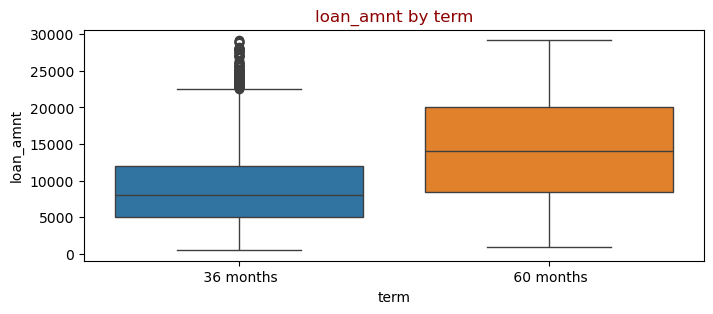

*** The attribute int_rate segmented by term


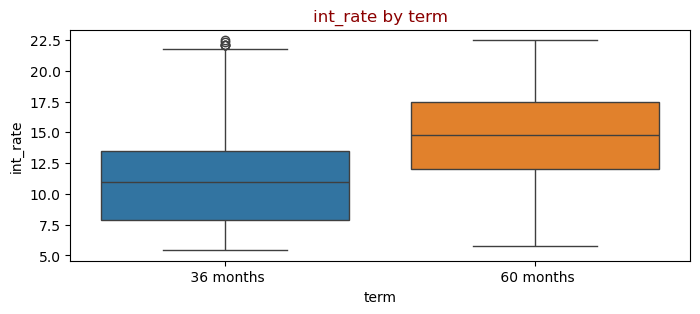

*** The attribute total_rec_prncp segmented by term


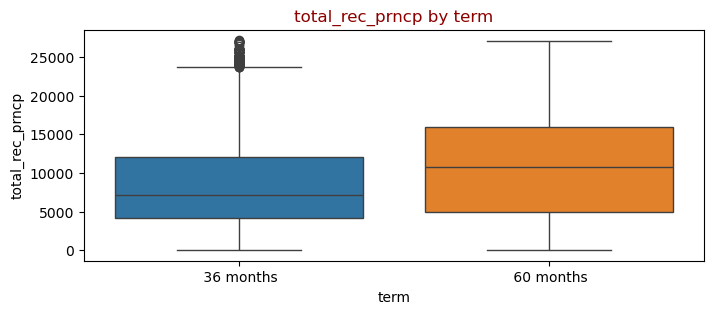

*** The attribute revol_util segmented by term


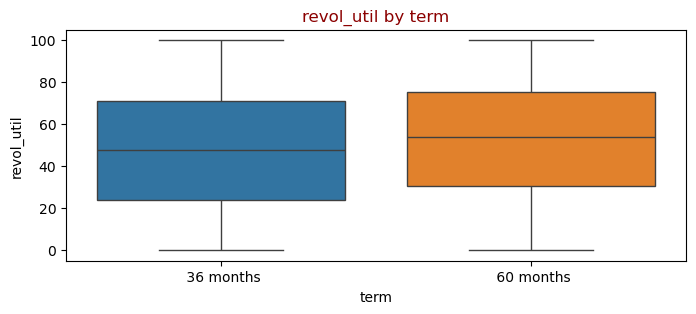

*** The attribute total_acc segmented by term


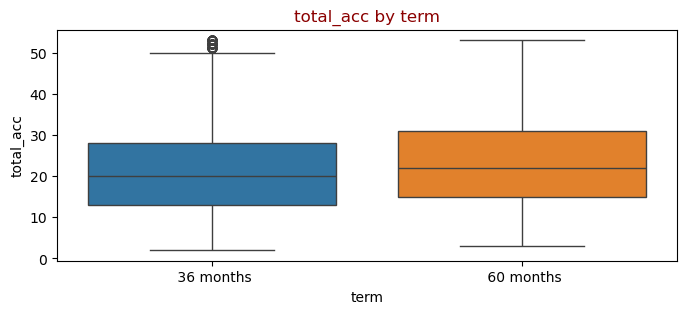

*** The attribute open_acc segmented by term


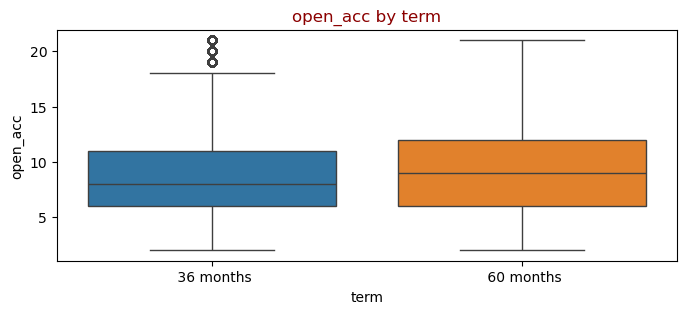

*** The attribute loan_amnt segmented by grade


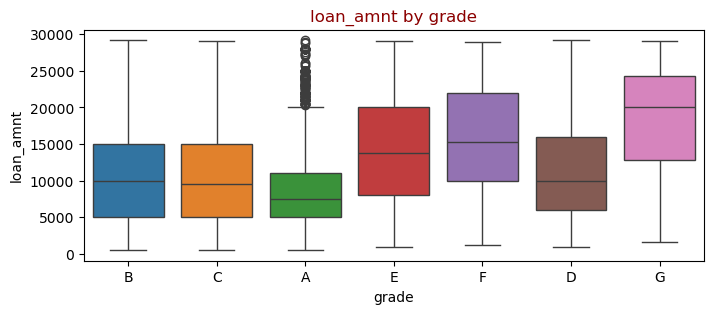

*** The attribute int_rate segmented by grade


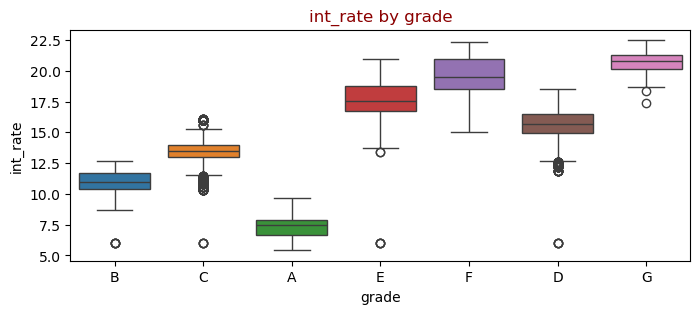

*** The attribute total_rec_prncp segmented by grade


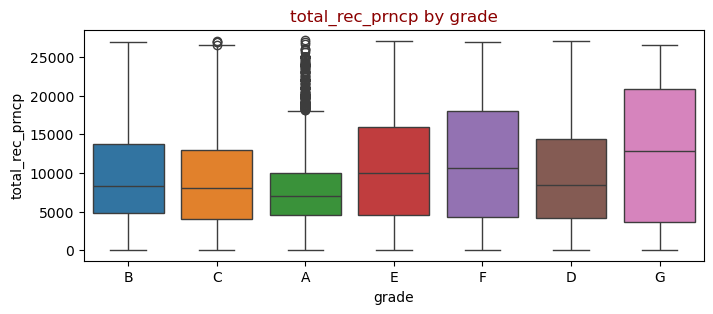

*** The attribute revol_util segmented by grade


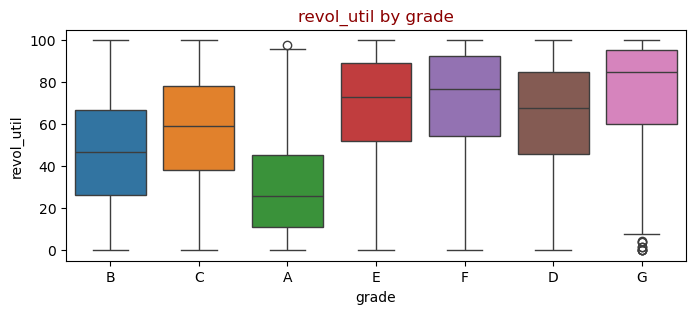

*** The attribute total_acc segmented by grade


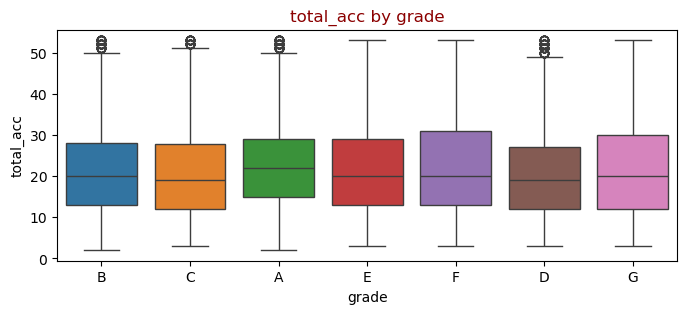

*** The attribute open_acc segmented by grade


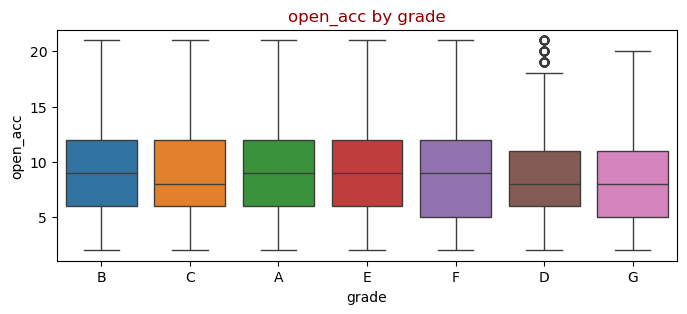

*** The attribute loan_amnt segmented by home_ownership


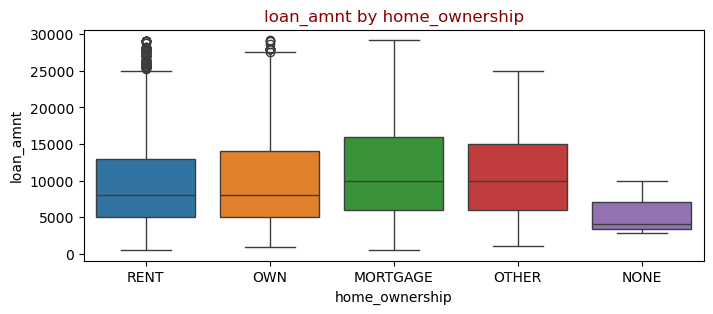

*** The attribute int_rate segmented by home_ownership


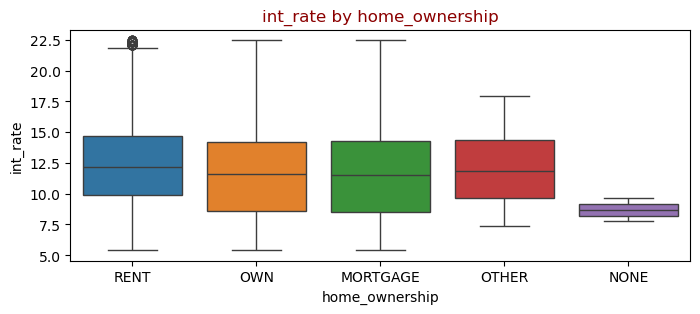

*** The attribute total_rec_prncp segmented by home_ownership


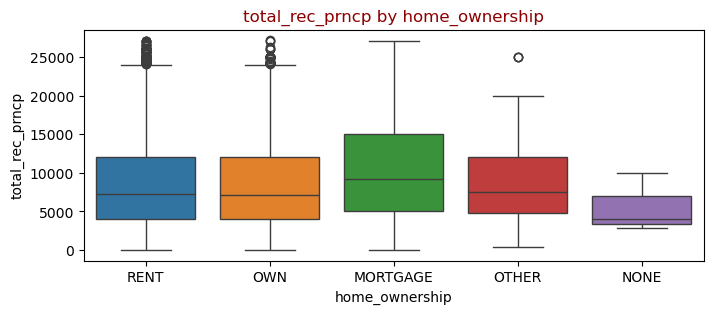

*** The attribute revol_util segmented by home_ownership


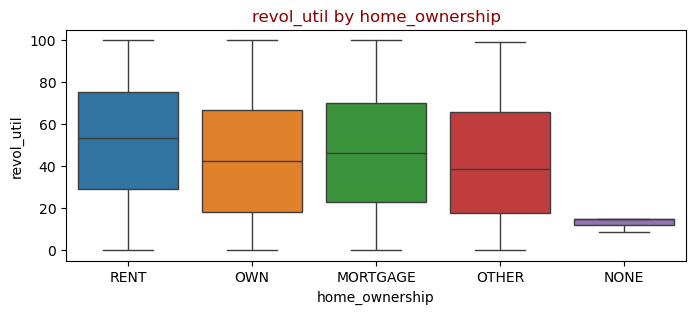

*** The attribute total_acc segmented by home_ownership


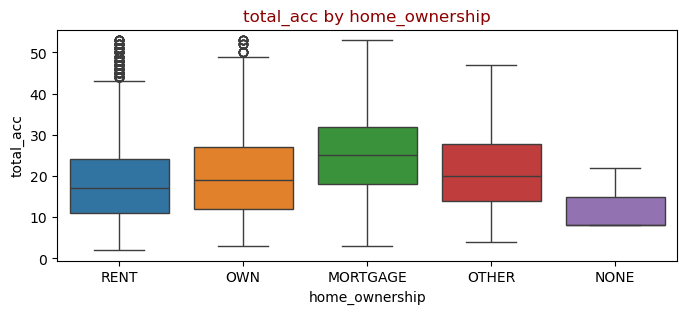

*** The attribute open_acc segmented by home_ownership


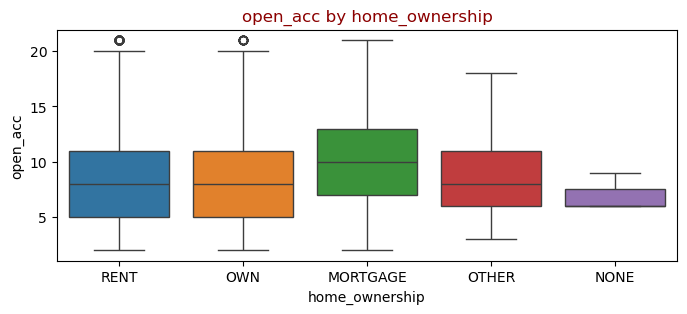

*** The attribute loan_amnt segmented by verification_status


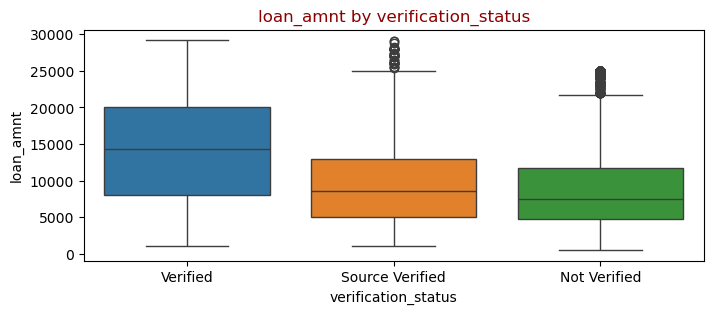

*** The attribute int_rate segmented by verification_status


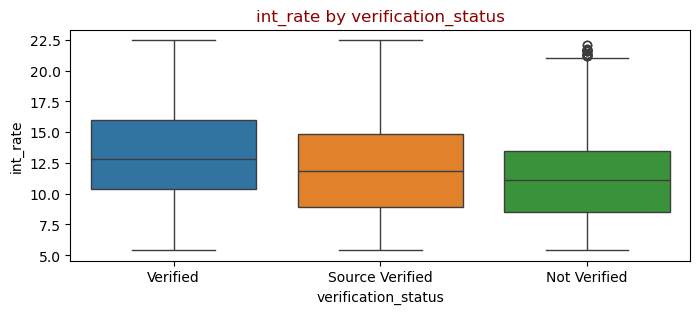

*** The attribute total_rec_prncp segmented by verification_status


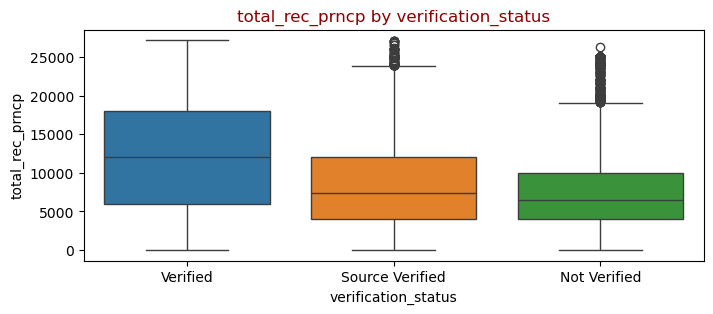

*** The attribute revol_util segmented by verification_status


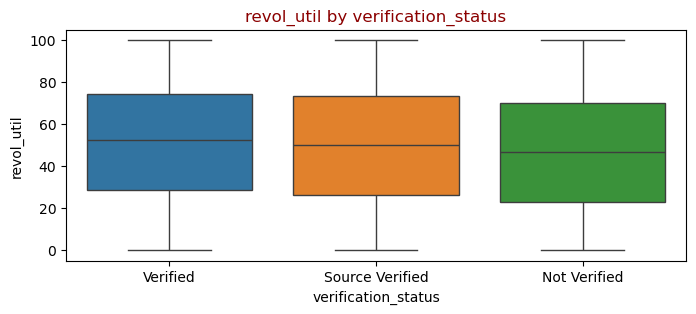

*** The attribute total_acc segmented by verification_status


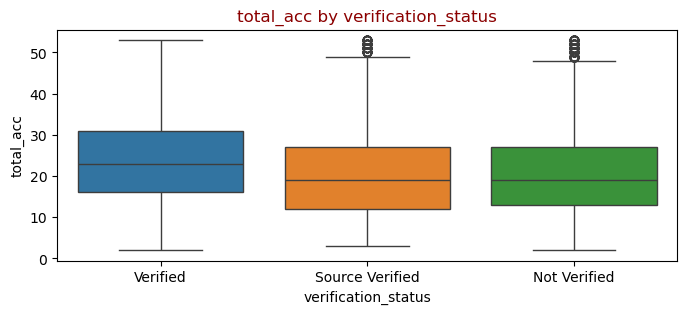

*** The attribute open_acc segmented by verification_status


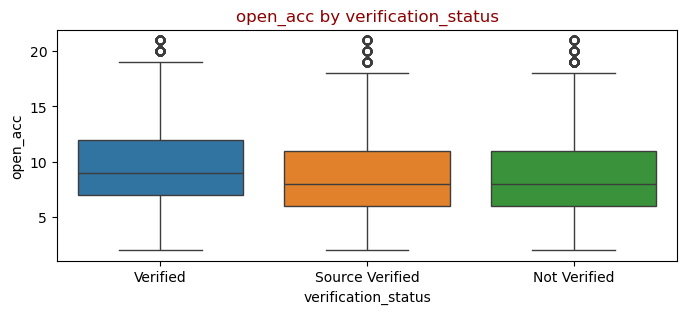

*** The attribute loan_amnt segmented by purpose


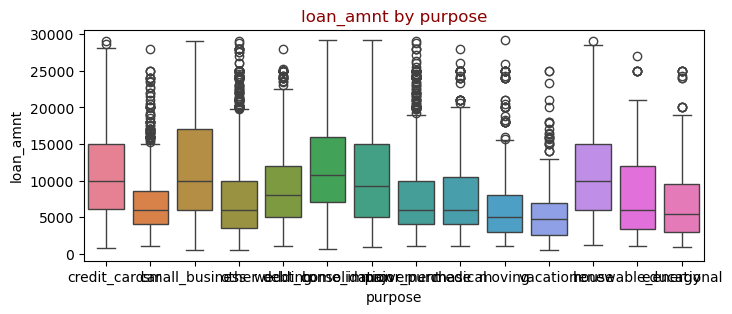

*** The attribute int_rate segmented by purpose


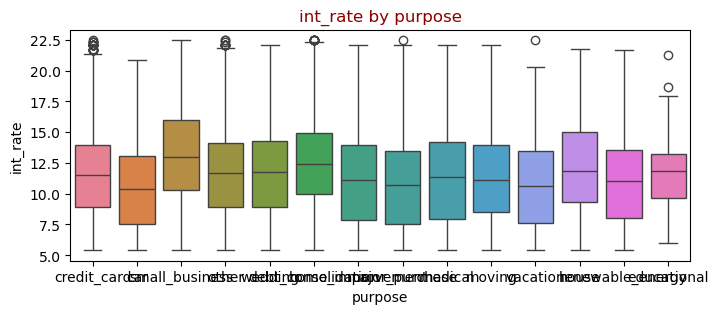

*** The attribute total_rec_prncp segmented by purpose


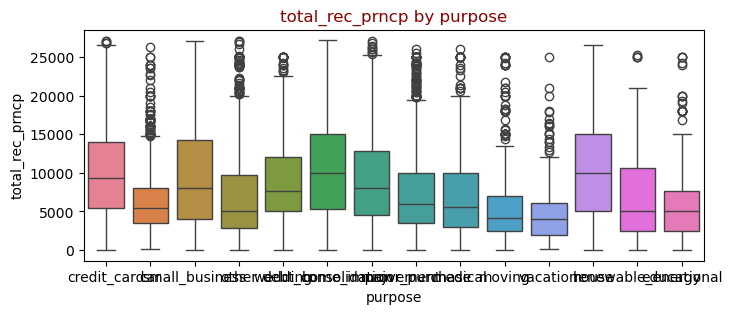

*** The attribute revol_util segmented by purpose


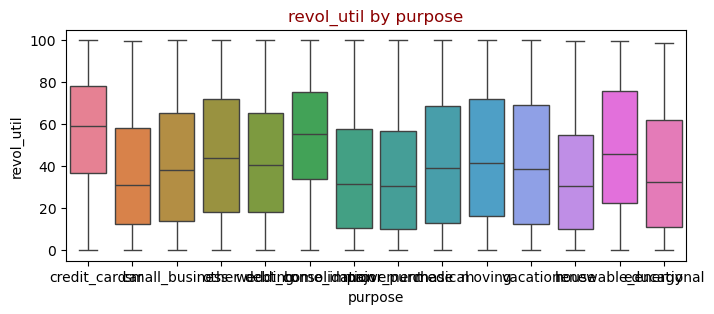

*** The attribute total_acc segmented by purpose


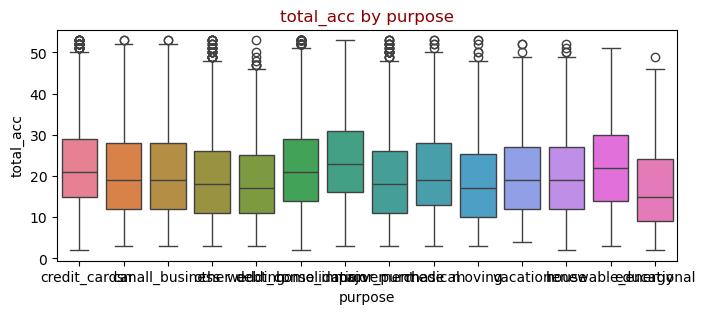

*** The attribute open_acc segmented by purpose


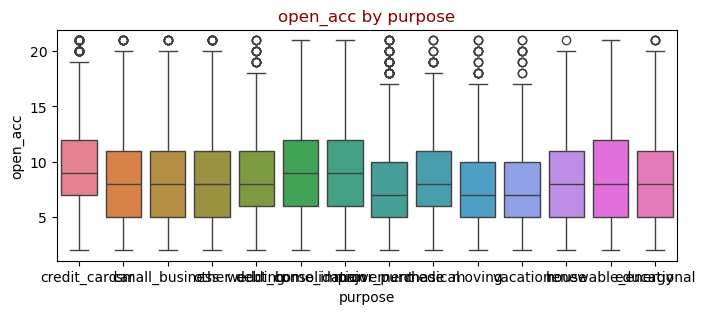

In [462]:
quant_attr_list = ['loan_amnt', 'int_rate', 'total_rec_prncp',  'revol_util',  'total_acc',  'open_acc'] #y columns
cate_attr_list = ['term',  'grade',  'home_ownership',  'verification_status',  'purpose'] #x columns
for cate in cate_attr_list:
    for quant in quant_attr_list:
        print ('*** The attribute {} segmented by {}'.format(quant, cate))
        df_no_out = remove_outliers(df_loan, quant)
        plt.figure(figsize=(8, 3))
        sns.boxplot(data=df_no_out, y=quant, x=cate,hue=cate)
        plt.title(str(quant) + ' by ' + str(cate), color='darkred')
        plt.show()

### Inferences for segmented analysis: 
- 'loan_amnt' vs. 'term': borrowers in term of greater than 60 months have higher loan amount than the other
- 'loan_amnt' vs. 'grade': borrowers from grades E, F, G seem to have higher loans than the others
- 'int_rate' vs. 'grade': borrowers in grade D/E/F/G are subject to a high interest rate
- 'revol_util' vs. 'grade': borrowers in grade A use the lowest amount of credit relative to all available revolving credit.
- 'loan_amnt' vs. 'verification_status': verified borrowers have higher loan amounts than others
- 'revol_util' vs. purpose: borrwers for credit cards have the highest amount of credit relative to all available revolving credit.

### 3.3.4 Some heatmaps 

1.*** Heatmap of 'Default Rates' by 'term'' and 'grade'


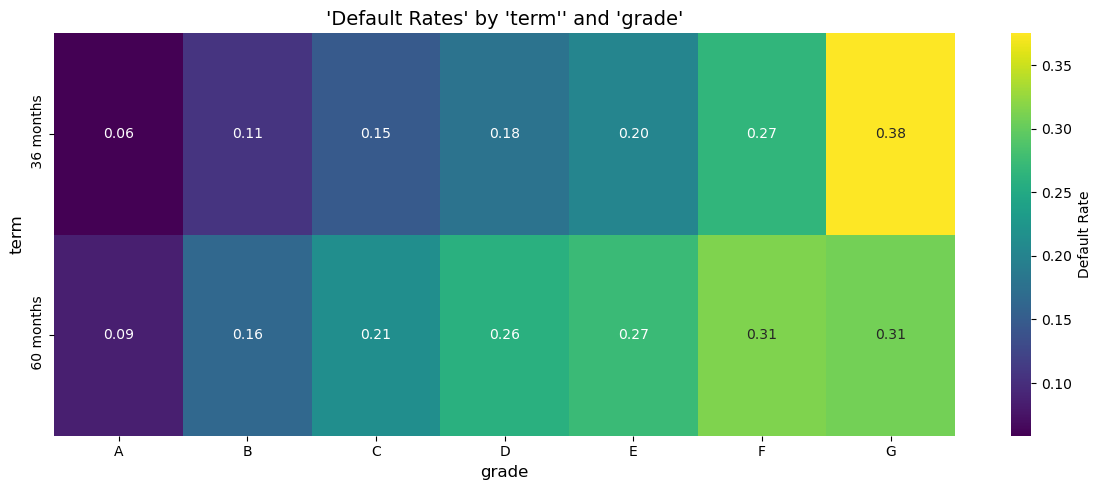

2.*** Heatmap of 'Default Rates' by 'term'' and 'verification_status'


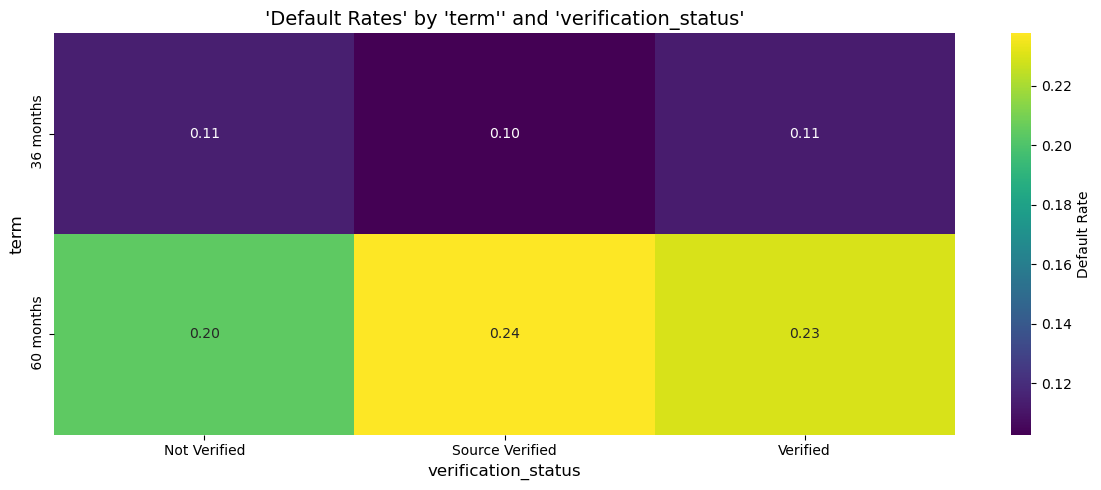

3.*** Heatmap of 'Default Rates' by 'term'' and 'loan_status'


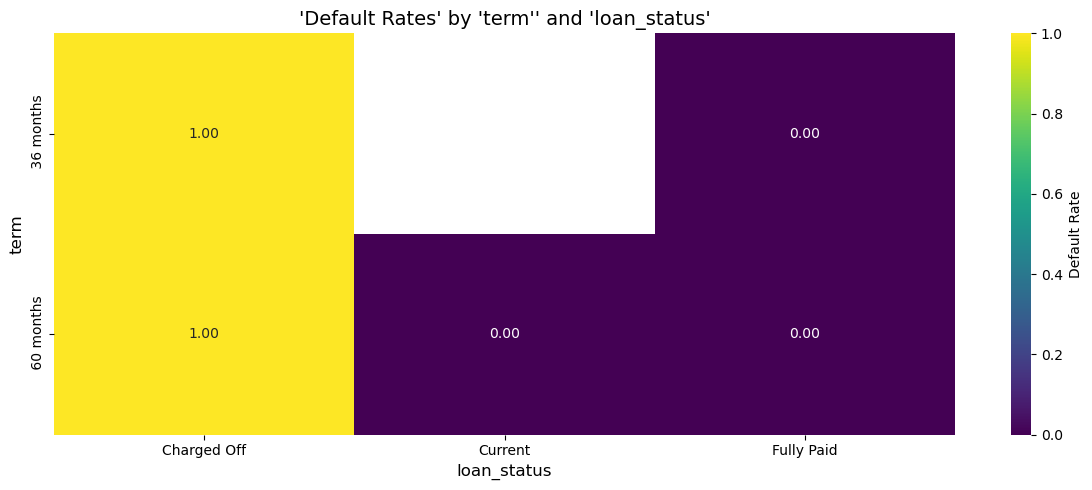

4.*** Heatmap of 'Default Rates' by 'term'' and 'emp_length'


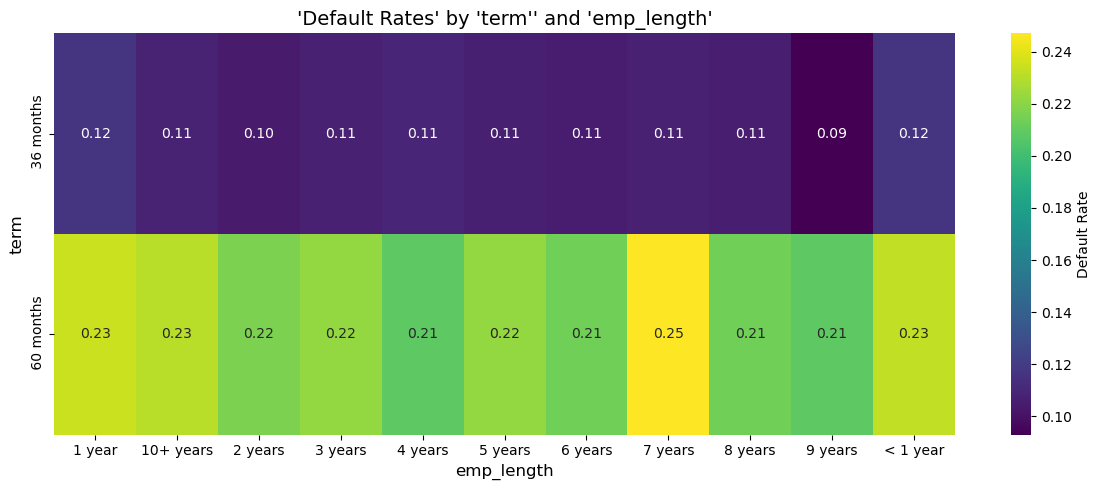

5.*** Heatmap of 'Default Rates' by 'term'' and 'home_ownership'


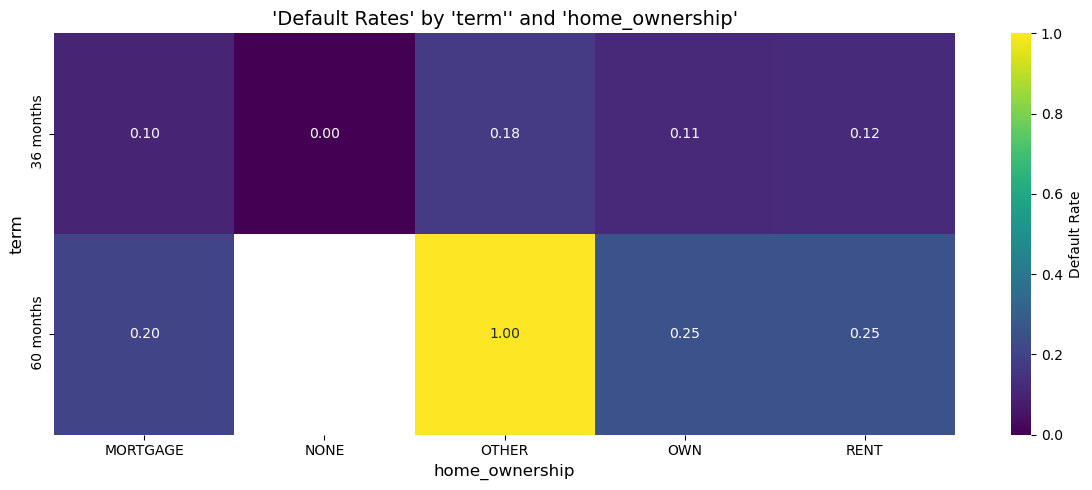

6.*** Heatmap of 'Default Rates' by 'term'' and 'purpose'


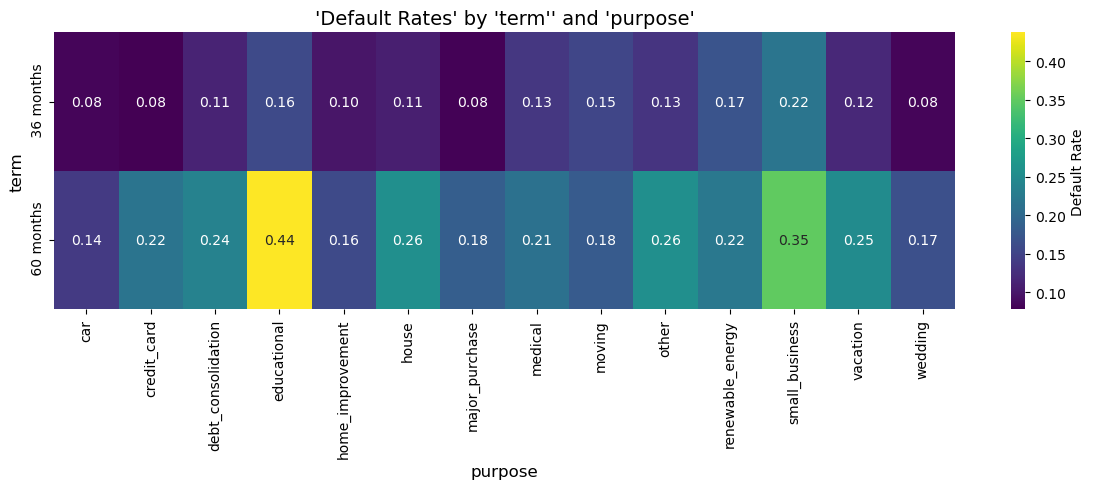

7.*** Heatmap of 'Default Rates' by 'term'' and 'addr_state'


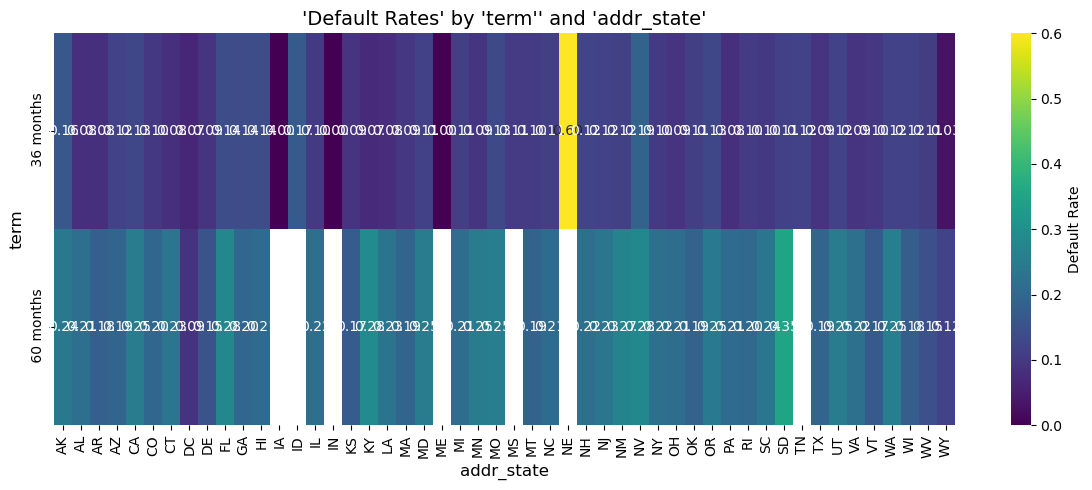

8.*** Heatmap of 'Default Rates' by 'grade'' and 'verification_status'


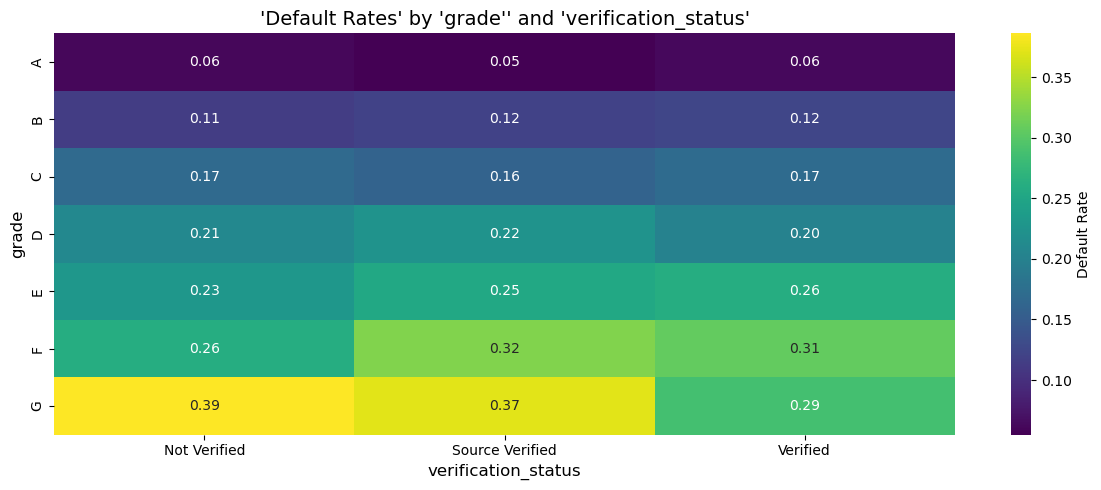

9.*** Heatmap of 'Default Rates' by 'grade'' and 'loan_status'


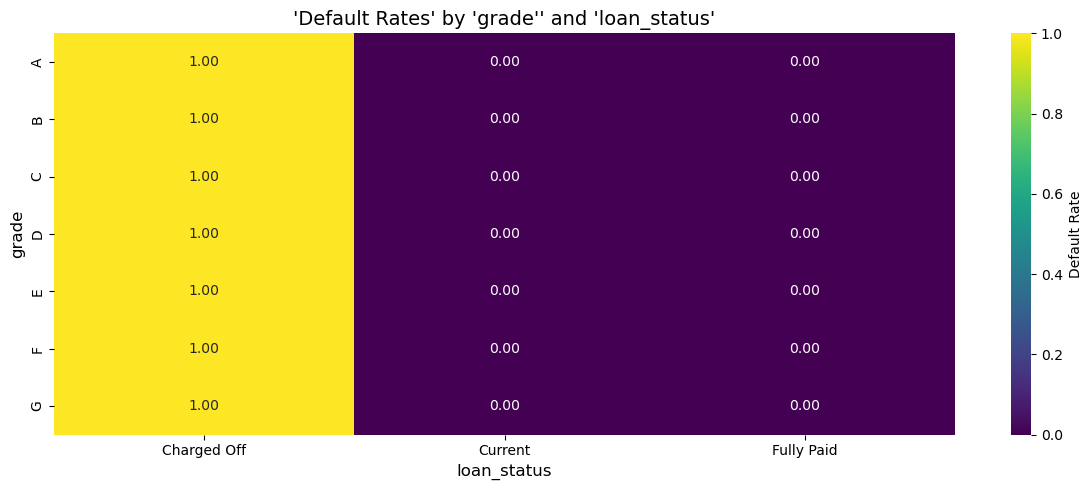

10.*** Heatmap of 'Default Rates' by 'grade'' and 'emp_length'


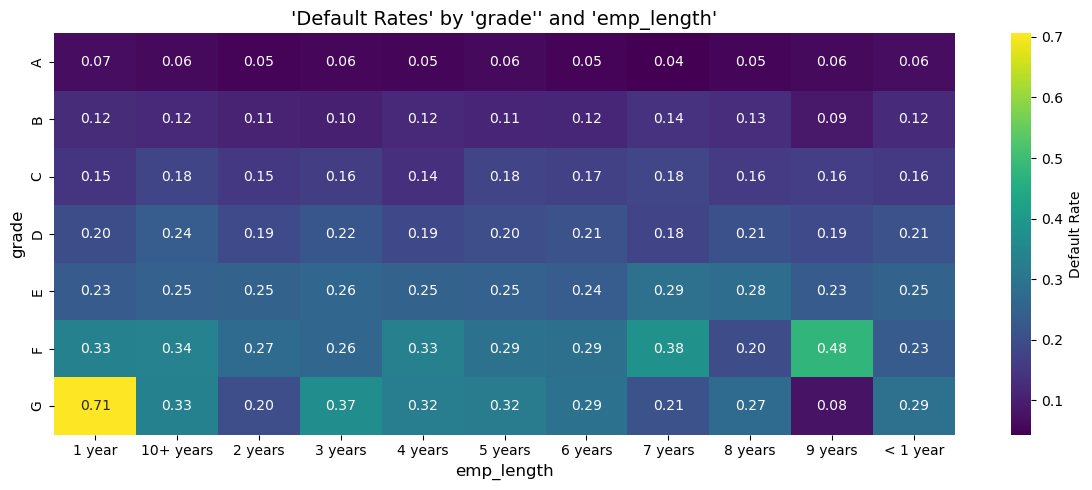

11.*** Heatmap of 'Default Rates' by 'grade'' and 'home_ownership'


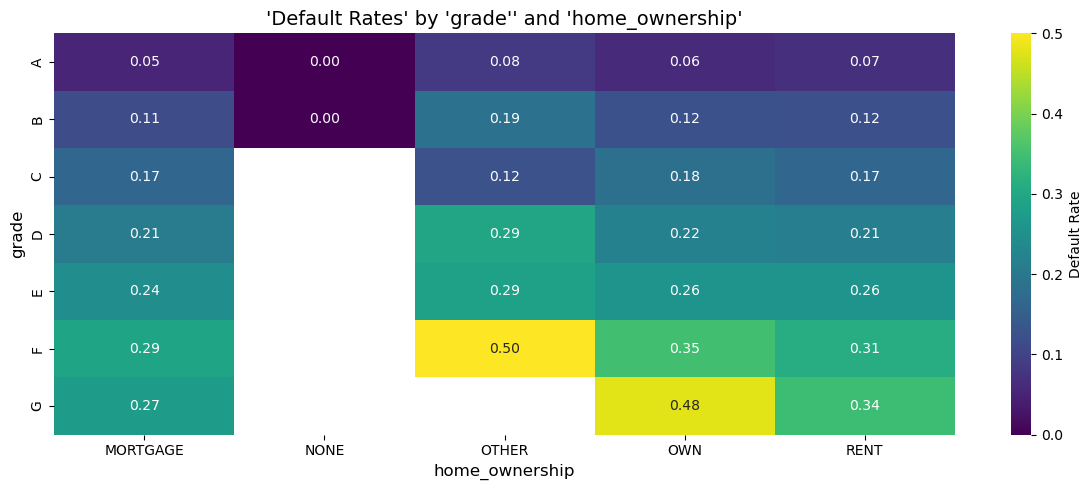

12.*** Heatmap of 'Default Rates' by 'grade'' and 'purpose'


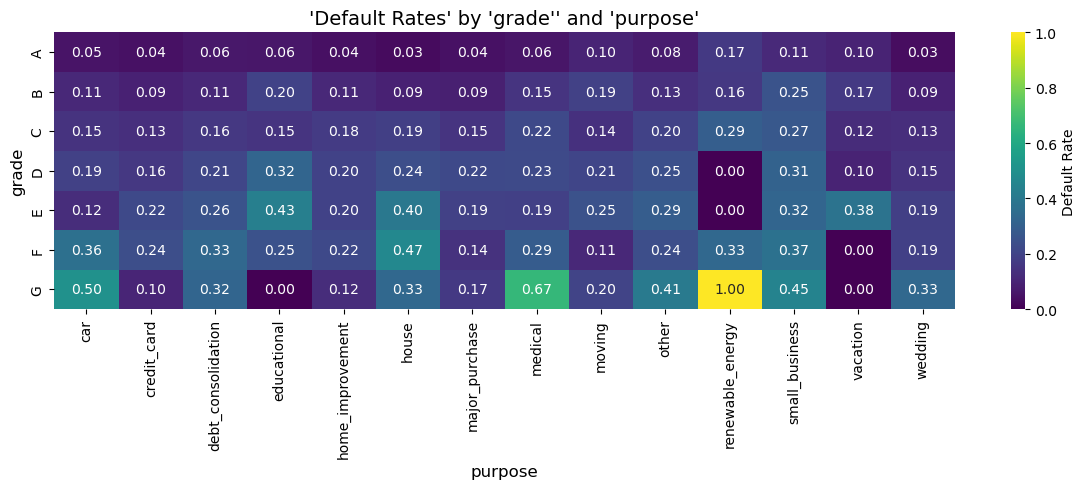

13.*** Heatmap of 'Default Rates' by 'grade'' and 'addr_state'


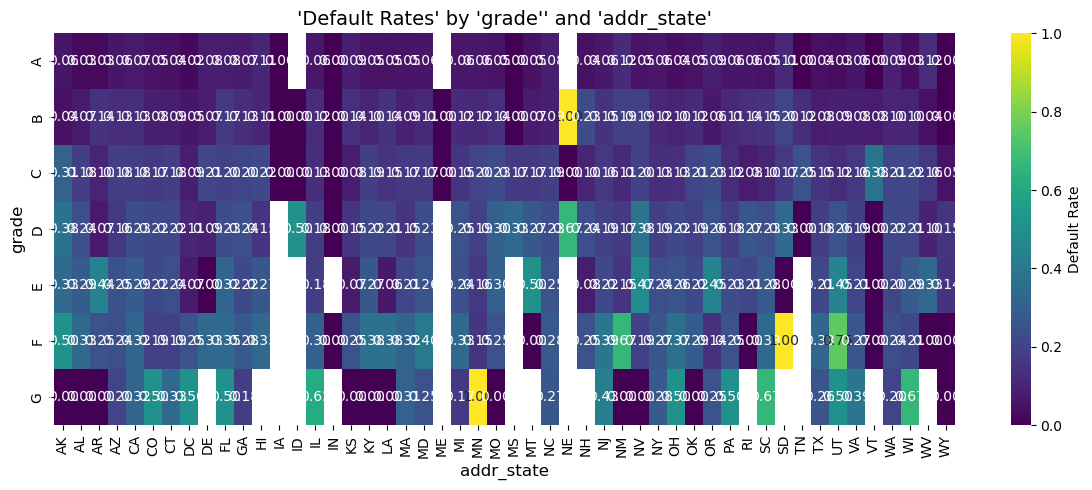

14.*** Heatmap of 'Default Rates' by 'verification_status'' and 'loan_status'


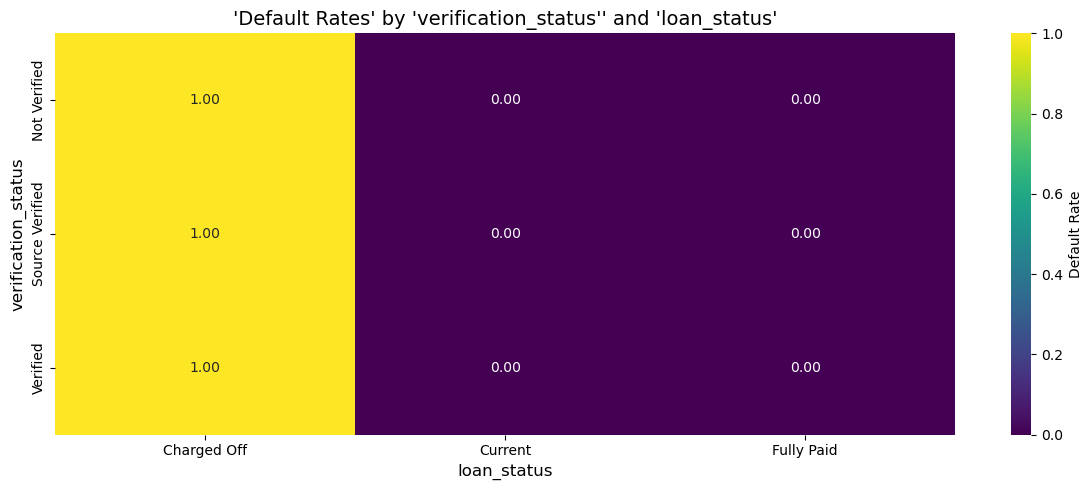

15.*** Heatmap of 'Default Rates' by 'verification_status'' and 'emp_length'


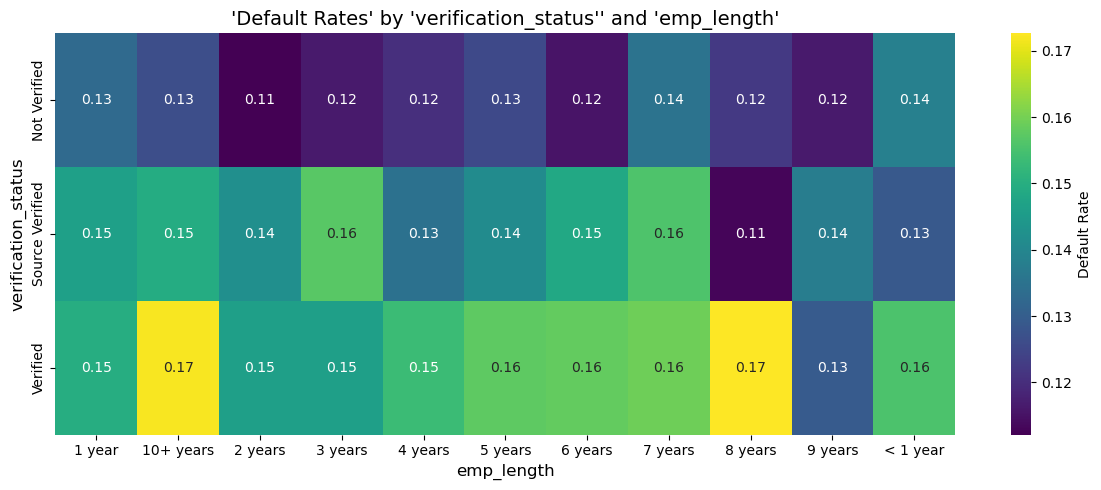

16.*** Heatmap of 'Default Rates' by 'verification_status'' and 'home_ownership'


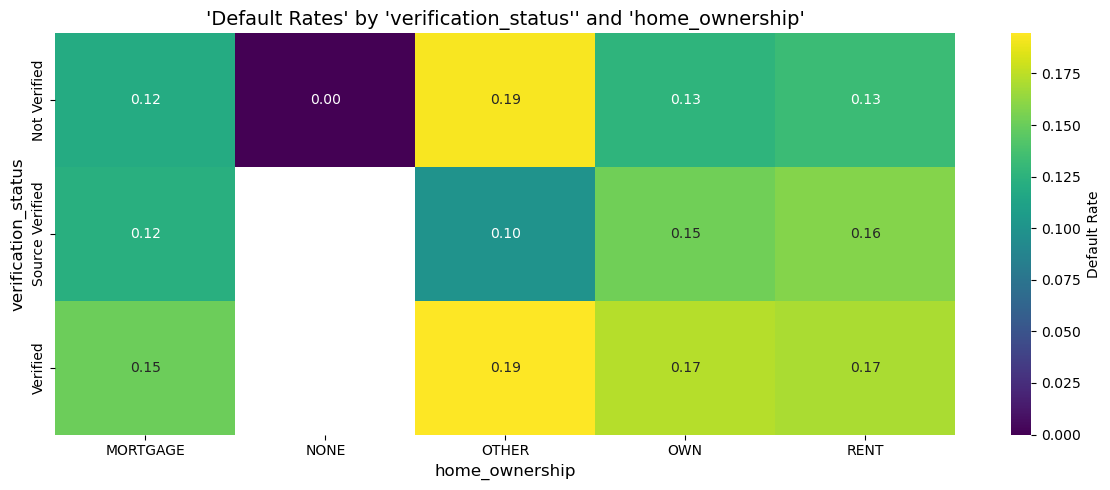

17.*** Heatmap of 'Default Rates' by 'verification_status'' and 'purpose'


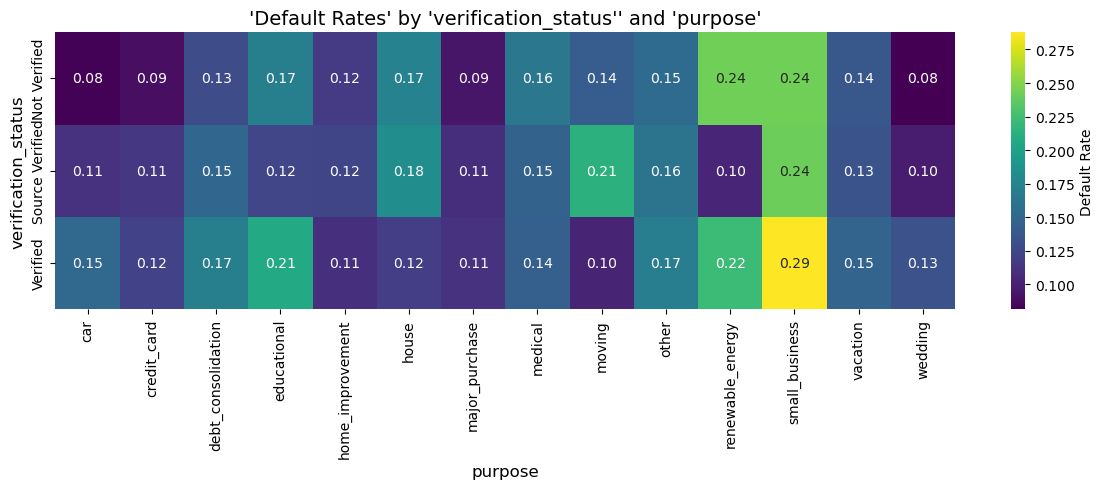

18.*** Heatmap of 'Default Rates' by 'verification_status'' and 'addr_state'


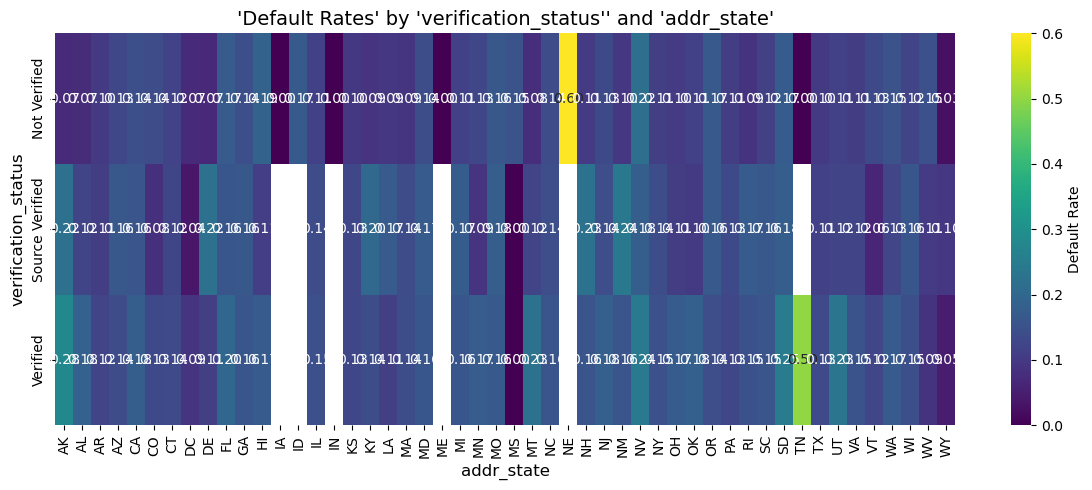

19.*** Heatmap of 'Default Rates' by 'loan_status'' and 'emp_length'


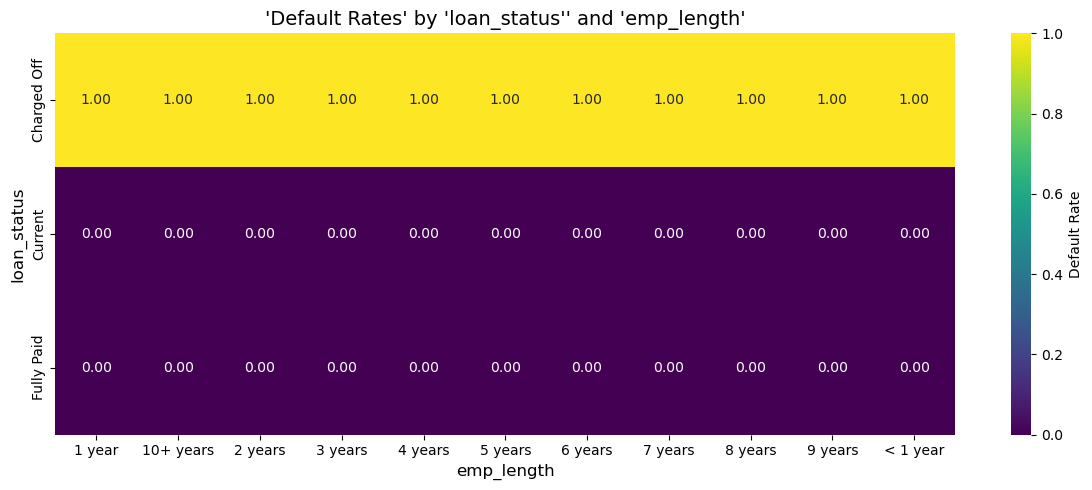

20.*** Heatmap of 'Default Rates' by 'loan_status'' and 'home_ownership'


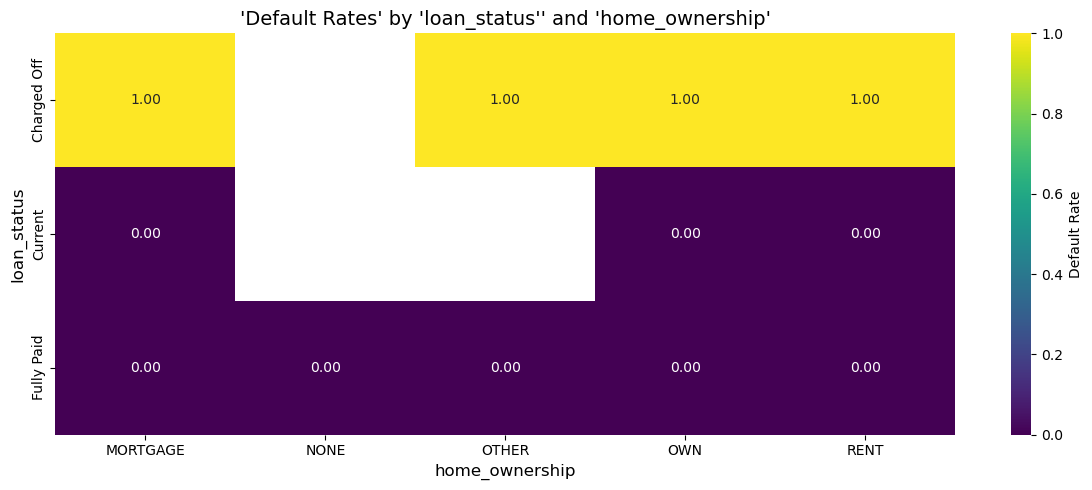

21.*** Heatmap of 'Default Rates' by 'loan_status'' and 'purpose'


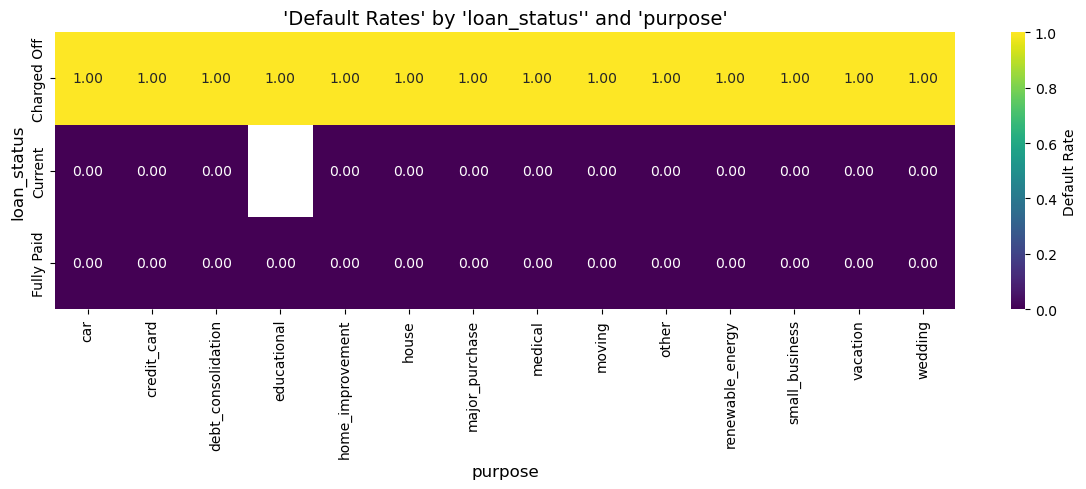

22.*** Heatmap of 'Default Rates' by 'loan_status'' and 'addr_state'


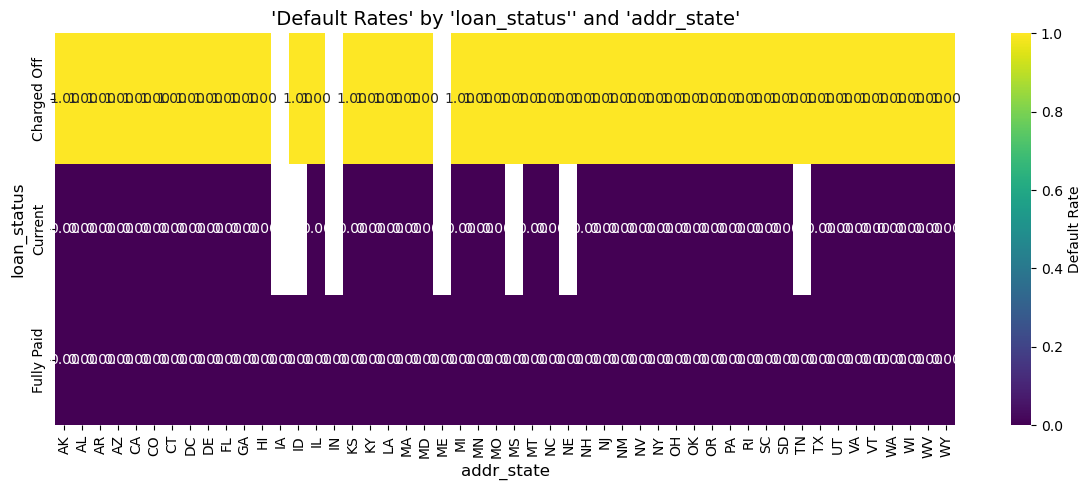

23.*** Heatmap of 'Default Rates' by 'emp_length'' and 'home_ownership'


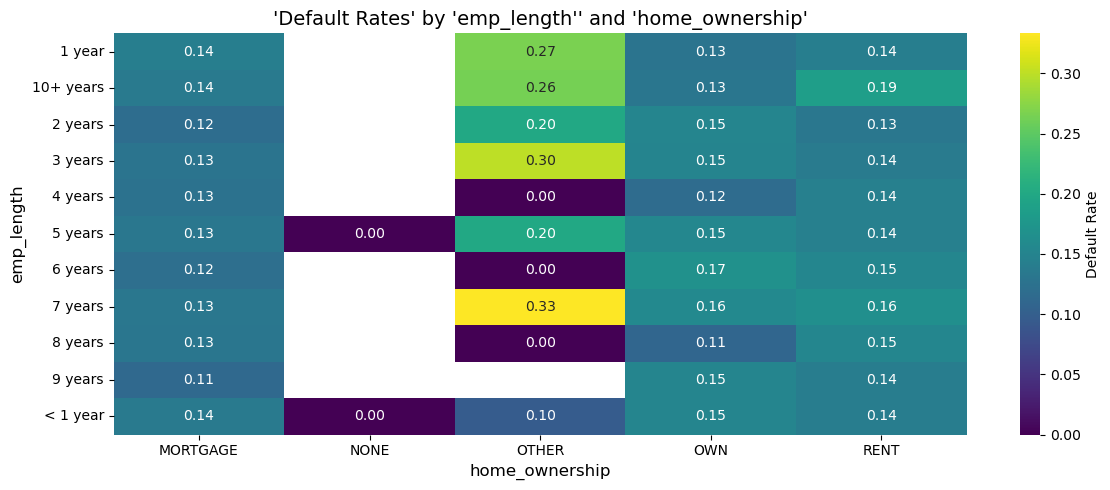

24.*** Heatmap of 'Default Rates' by 'emp_length'' and 'purpose'


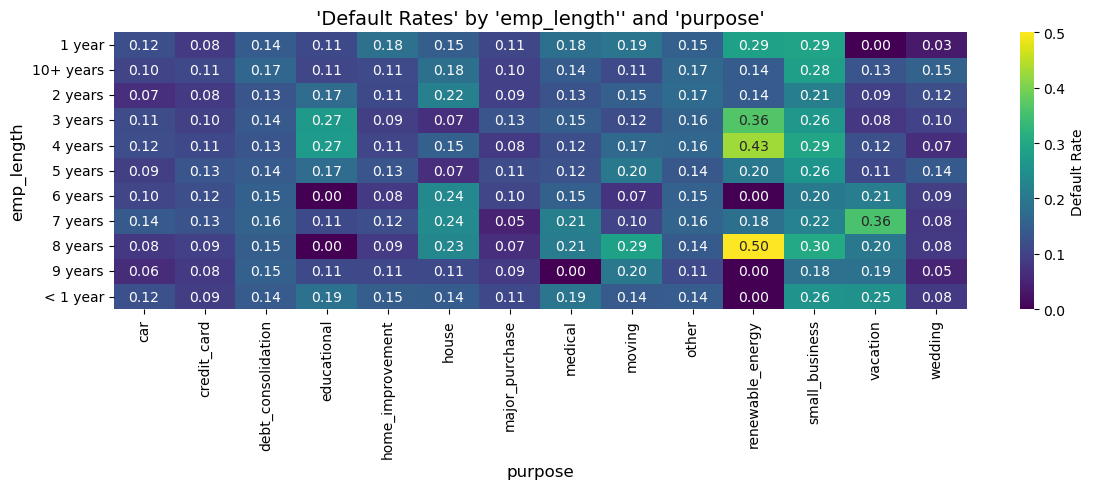

25.*** Heatmap of 'Default Rates' by 'emp_length'' and 'addr_state'


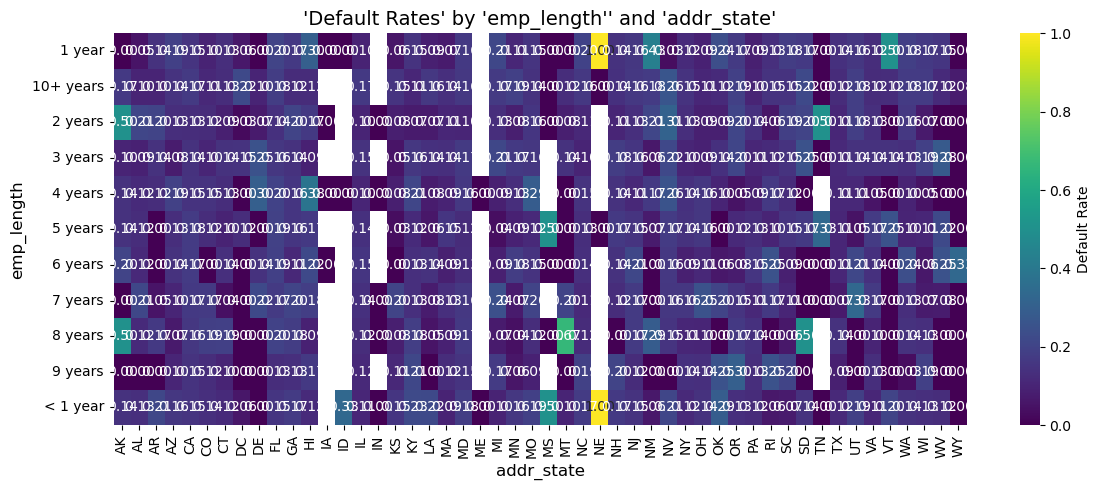

26.*** Heatmap of 'Default Rates' by 'home_ownership'' and 'purpose'


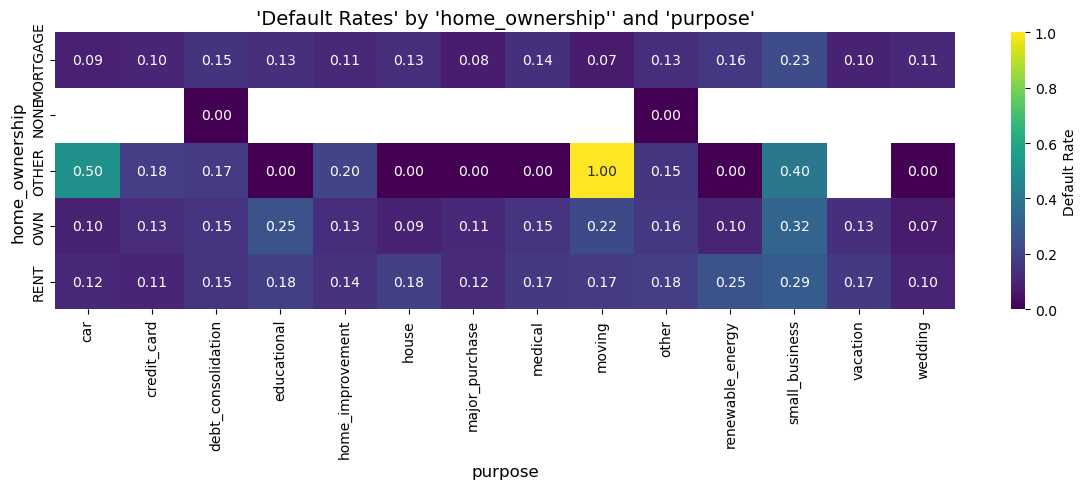

27.*** Heatmap of 'Default Rates' by 'home_ownership'' and 'addr_state'


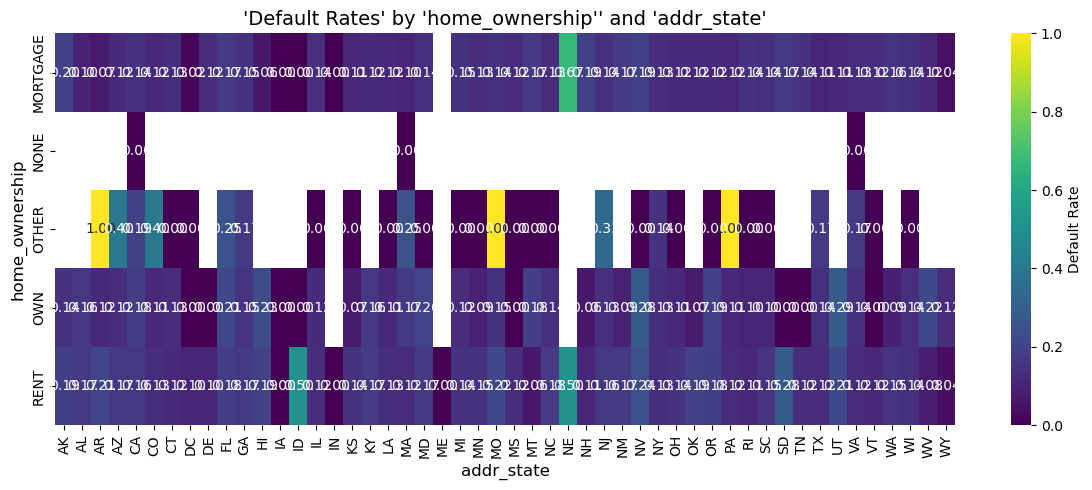

28.*** Heatmap of 'Default Rates' by 'purpose'' and 'addr_state'


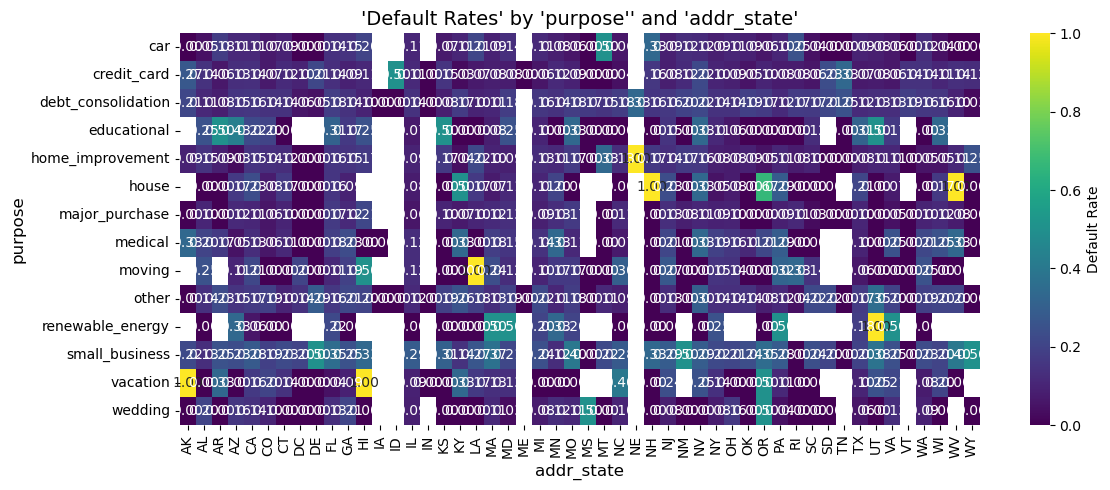

In [195]:
# List of attribute to segment
attr_to_heatmap = ['term',  'grade',
                'verification_status', 'loan_status',
                'emp_length', 'home_ownership',
                 'purpose', 'addr_state'
                 ]
num = 1
for i in range(0, len(attr_to_heatmap)):
    for j in range(i+1, len(attr_to_heatmap)):
        print ("{}.*** Heatmap of 'Default Rates' by '{}'' and '{}'".format(num, attr_to_heatmap[i], attr_to_heatmap[j]))
        # Pair these attributes 
        default_rate = df_loan.groupby([attr_to_heatmap[i], attr_to_heatmap[j]])['has_defaulted'].mean().unstack()
        # Plot the heatmap
        plt.figure(figsize=(12, 5))
        sns.heatmap(default_rate, annot=True, cmap="viridis", fmt=".2f", cbar_kws={'label': 'Default Rate'})

        # Set title and label
        plt.title("'Default Rates' by '{}'' and '{}'".format(attr_to_heatmap[i], attr_to_heatmap[j]), fontsize=14)
        plt.xlabel(str(attr_to_heatmap[j]), fontsize=12)
        plt.ylabel(str(attr_to_heatmap[i]), fontsize=12)
        plt.tight_layout()

        # Hiển thị biểu đồ
        plt.show()
        num += 1


### Inferences for segmented analysis:
- 'Default Rates' by 'term'' and 'grade': borrowers from grade 'G' in term = 36 months have the highest rate of default.
- 'Default Rates' by 'term'' and 'verification_status': borrowers from - 'source verified' group in term = 60 months have the highest rate of default.
- 'Default Rates' by 'term'' and 'home_ownership':  borrowers from 'other' group in term = 60 months have the highest rate of default.
-  'Default Rates' by 'term'' and 'purpose': borrowers from 'educational' group in term = 60 months have the highest rate of default.
- 'Default Rates' by 'term'' and 'addr_state': borrowers from 'NE' group in term = 36 months have the highest rate of default.
- 'Default Rates' by 'grade'' and 'verification_status':  borrowers from 'Not verified' group and grade=G have the highest rate of default.
- 'Default Rates' by 'grade'' and 'emp_length': borrowers from '1 year' group and grade=G have the highest rate of default.
- 'Default Rates' by 'grade'' and 'home_ownership': borrowers from 'OTHER' group and grade=f have the highest rate of default.
- 'Default Rates' by 'grade'' and 'purpose': borrowers from 'renewable_enetgry' group and grade=G have the highest rate of default.
- 'Default Rates' by 'verification_status'' and 'home_ownership': borrowers from 'OTHER' group have the highest rate of default.
-'Default Rates' by 'verification_status'' and 'purpose': borrowers from 'small_business' group have the highest rate of default.


### 3.3.5 Some additional views:


#### A violin plot for loan amount distribution by loan status and verification status

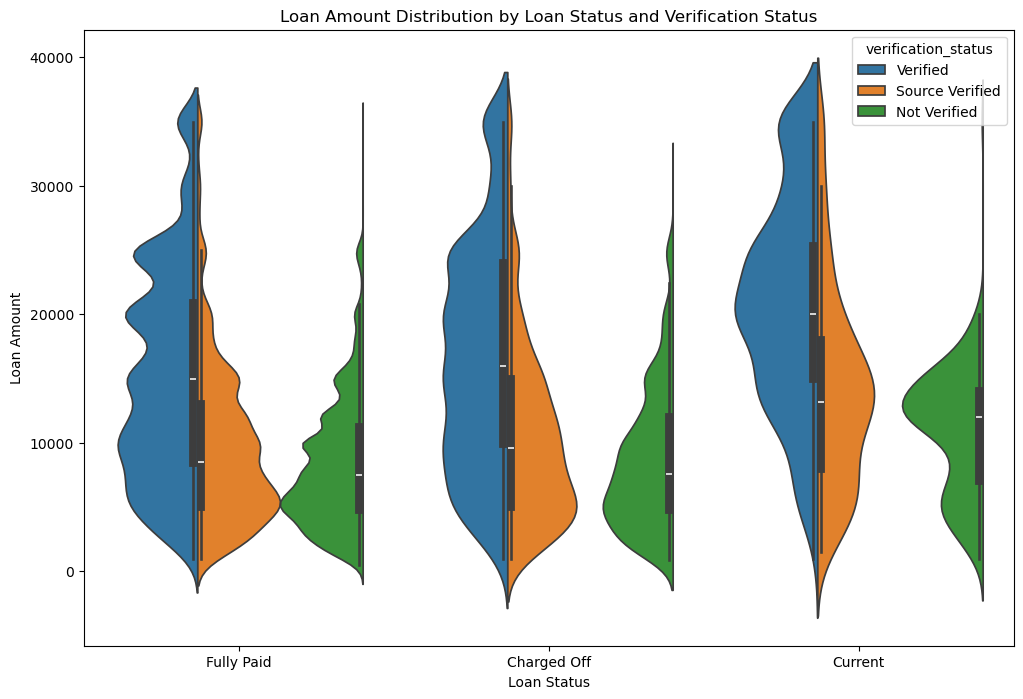

In [206]:
# Clean the 'loan_status' and 'verification_status' columns by stripping spaces
df_loan['loan_status'] = df_loan['loan_status'].str.strip()
df_loan['verification_status'] = df_loan['verification_status'].str.strip()

# Set up the plot
plt.figure(figsize=(12, 8))

# Create a violin plot for loan amount distribution by loan status and verification status
sns.violinplot(x='loan_status', y='loan_amnt', hue='verification_status', data=df_loan, split=True)

# Set the title and labels
plt.title('Loan Amount Distribution by Loan Status and Verification Status')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')

# Display the plot
plt.show()

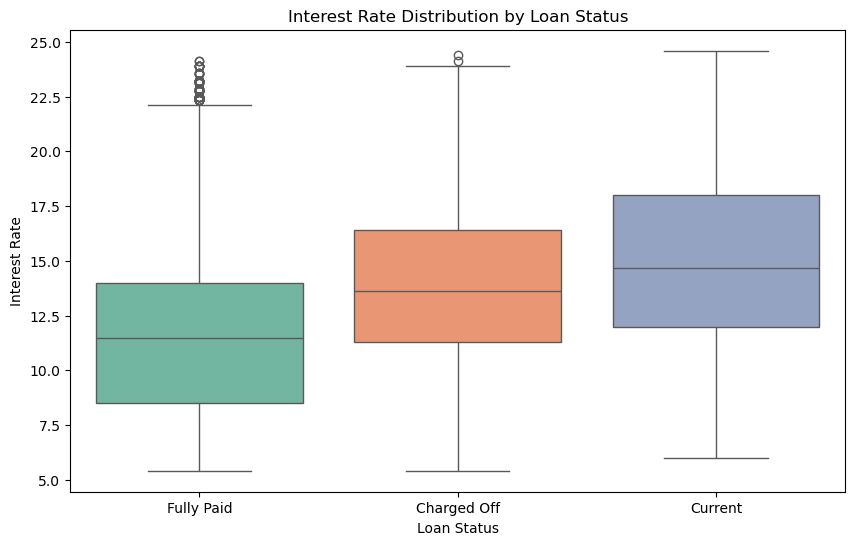

In [208]:
# Investigate the 'int_rate', 'loan_status'

# Check for missing values in the relevant columns
df_loan[['loan_status', 'int_rate']].isnull().sum()

# Clean 'loan_status' column by stripping any extra spaces
df_loan['loan_status'] = df_loan['loan_status'].str.strip()

# Filter the dataset for the loan statuses of interest
df_filtered = df_loan[df_loan['loan_status'].isin(['Fully Paid', 'Charged Off', 'Current'])]

# Drop rows with missing interest rates (if any)
df_filtered = df_filtered.dropna(subset=['int_rate'])

# Set up the plot
plt.figure(figsize=(10, 6))

# Create a boxplot for interest rate by loan status
sns.boxplot(x='loan_status', y='int_rate', data=df_filtered, palette='Set2')

# Set the title and labels
plt.title('Interest Rate Distribution by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Interest Rate')

# Display the plot
plt.show()


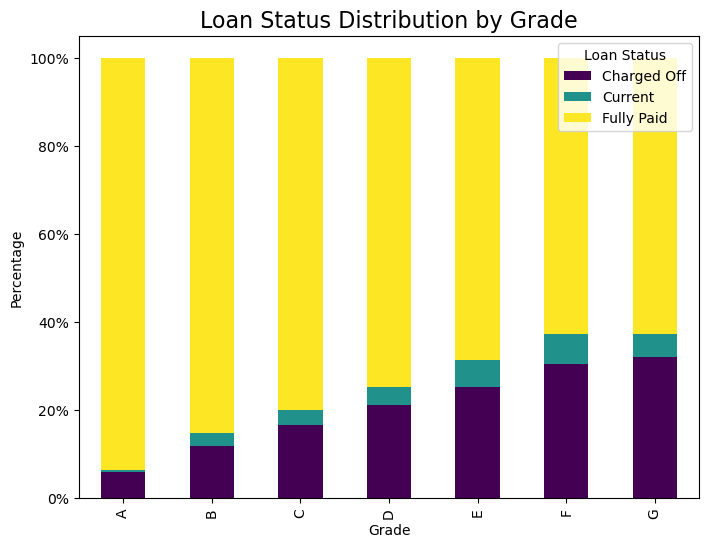

In [249]:
from matplotlib.ticker import FuncFormatter
# Calcute the percentage
status_counts = df_loan.groupby(["grade", "loan_status"]).size().reset_index(name='count')
# print(status_counts)
pivot = status_counts.pivot(index="grade", columns="loan_status", values="count").fillna(0)
pivot_percent = pivot.div(pivot.sum(axis=1), axis=0)
# draw the stacked bar plot
ax  = pivot_percent.plot(kind='bar', stacked=True ,figsize=(8, 6), colormap="viridis")
plt.title("Loan Status Distribution by Grade", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*100:.0f}%"))
plt.ylabel("Percentage")
plt.xlabel("Grade")
plt.legend(title="Loan Status")
plt.show()